## Set-up

### Import libraries

In [132]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler, PowerTransformer
import colorsys
import textwrap
import plotly.graph_objects as go
import jenkspy

### Fetch dataset

In [3]:
online_retail = fetch_ucirepo(id=352)

### Read dataset

In [4]:
df = online_retail.data.features

## Data Exploration

### Dataframe information

In [5]:

def basic_column_info_pd(df):
    column_info = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes,
        'Non-Null Count': df.count(),
        'Null Count': df.isnull().sum()
    })
    return column_info

display(basic_column_info_pd(df))

,Column Name,Data Type,Non-Null Count,Null Count
Description,Description,object,540455,1454
Quantity,Quantity,int64,541909,0
InvoiceDate,InvoiceDate,object,541909,0
UnitPrice,UnitPrice,float64,541909,0
CustomerID,CustomerID,float64,406829,135080
Country,Country,object,541909,0


### Basic Preprocessing

In [6]:
def basic_df_cleaning(df):
    
    df_cleaned = df.copy()
    
    # 1. Convert 'InvoiceDate' to datetime
    df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
    
    # 2. Trim whitespace from string columns
    string_columns = df_cleaned.select_dtypes(include=['object']).columns
    df_cleaned[string_columns] = df_cleaned[string_columns].apply(lambda x: x.str.strip())
    
    # 3. Create a new column for total price
    df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']
    
    return df_cleaned

df = basic_df_cleaning(df)

In [7]:
def calculate_column_stats(df):
    numeric_datetime_cols = df.select_dtypes(include=['number', 'datetime']).columns
    stats = []

    for col in numeric_datetime_cols:
        col_stats = {
            'column': col,
            'min': df[col].min(),
            'max': df[col].max(),
            'median': df[col].median(),
            'mean': df[col].mean(),
            'mode': df[col].mode().iloc[0] if not df[col].mode().empty else np.nan,
            'distinct_count': df[col].nunique(),
            'dtype': df[col].dtype
        }
        stats.append(col_stats)

    return pd.DataFrame(stats)

display(calculate_column_stats(df))

,column,min,max,median,mean,mode,distinct_count,dtype
0,Quantity,-80995,80995,3.0,9.55225,1,722,int64
1,InvoiceDate,2010-12-01 08:26:00,2011-12-09 12:50:00,2011-07-19 17:17:00,2011-07-04 13:34:57.156386048,2011-10-31 14:41:00,23260,datetime64[ns]
2,UnitPrice,-11062.06,38970.0,2.08,4.611114,1.25,1630,float64
3,CustomerID,12346.0,18287.0,15152.0,15287.69057,17841.0,4372,float64
4,TotalPrice,-168469.6,168469.6,9.75,17.987795,15.0,6204,float64


### Distinct values

In [8]:
def create_distinct_values_df(df):
  
  distinct_counts = df.nunique()

  
  distinct_counts_df = pd.DataFrame({
    'Column Name': distinct_counts.index,
    'Distinct Value Count': distinct_counts.values
  })
  
  distinct_counts_df = distinct_counts_df.sort_values('Distinct Value Count', ascending=False)
  
  return distinct_counts_df


display(create_distinct_values_df(df))

,Column Name,Distinct Value Count
2,InvoiceDate,23260
6,TotalPrice,6204
4,CustomerID,4372
0,Description,4211
3,UnitPrice,1630
1,Quantity,722
5,Country,38


### Null values

In [9]:
def analyse_null_descriptions(df):
    query = """
    SELECT 
        COUNT(DISTINCT CustomerID) as distinct_customers,
        MIN(UnitPrice) as min_price,
        MAX(UnitPrice) as max_price,
        COUNT(DISTINCT UnitPrice) as distinct_prices,
        COUNT(DISTINCT InvoiceDate) as distinct_invoice_dates,
        COUNT(DISTINCT Country) as distinct_country
    FROM df
    WHERE Description IS NULL
    """
    
    result = sqldf(query, locals())
    return result

analyse_null_descriptions(df).head()

,distinct_customers,min_price,max_price,distinct_prices,distinct_invoice_dates,distinct_country
0,0,0.0,0.0,1,1121,1


Fairly meaningless data. Distinct InvoiceDate values not equivalent to distinct invoices.

In [10]:

def filter_valid_descriptions(df):
    return df.dropna(subset=['Description'])

In [11]:
df = filter_valid_descriptions(df)

In [12]:
empty_customer_df = df[df['CustomerID'].isna()]

### Duplicates

In [13]:
def get_sorted_duplicates(df):
    
    df_cleaned = df.copy()
    
    duplicates = df_cleaned[df_cleaned.duplicated(keep=False)]
    
    return duplicates.sort_values(by=df.columns.tolist())

In [14]:
# percentage
def calculate_df_percentage(df_subset, df_full):
  
  count_rows = len(df_subset)
  total_rows = len(df_full)
  percentage = (count_rows / total_rows) * 100
  
  return percentage

In [15]:
def plot_duplicates_over_time(df):
    duplicates_sorted = get_sorted_duplicates(df)
    
    
    daily_duplicates = duplicates_sorted.groupby(duplicates_sorted['InvoiceDate'].dt.date).size()

    
    plt.figure(figsize=(12, 6))
    daily_duplicates.plot(kind='line')
    plt.title('Number of Duplicates Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Duplicates')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [16]:
def analyse_duplicates(df):
    duplicates_sorted = get_sorted_duplicates(df)
    
    result = []
    result.append(f"Number of duplicated rows: {len(duplicates_sorted)}")
    result.append(f"Number of unique rows that are duplicated: {len(duplicates_sorted) // 2}")
    result.append(f"Percentage of rows that are duplicates: {calculate_df_percentage(duplicates_sorted,df):.2f}%")

    
    date_range = duplicates_sorted['InvoiceDate'].agg(['min', 'max'])
    result.append("\nDate range of duplicated transactions:")
    result.append(date_range.to_string())

    return "\n".join(result)

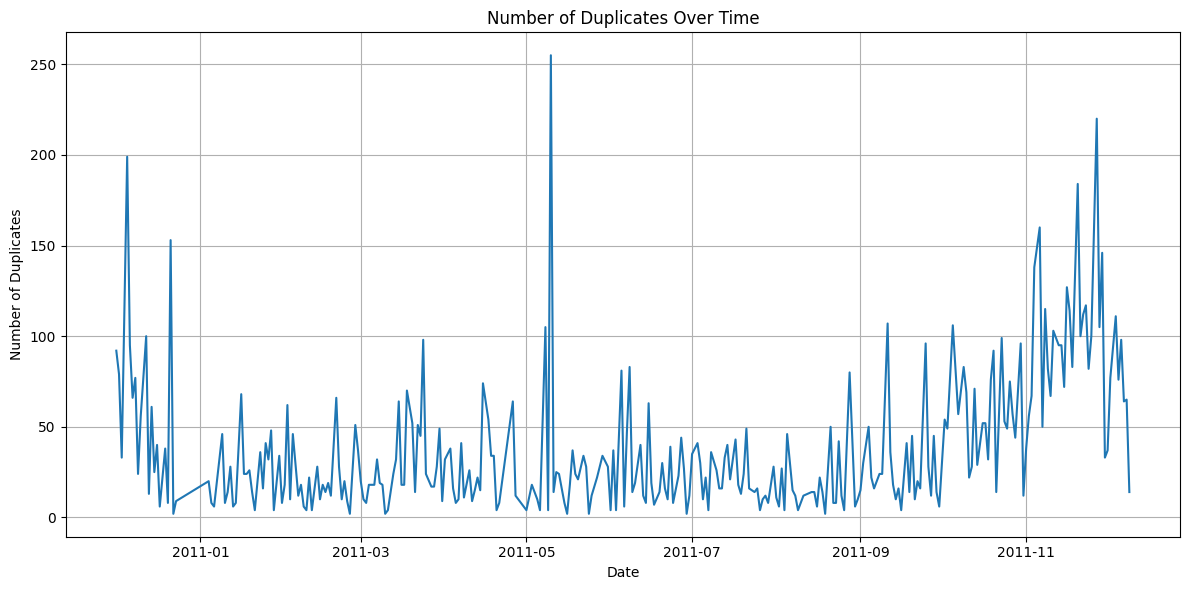

In [17]:
plot_duplicates_over_time(df)

In [18]:
print(analyse_duplicates(df))

Number of duplicated rows: 11431
Number of unique rows that are duplicated: 5715
Percentage of rows that are duplicates: 2.12%

Date range of duplicated transactions:
min   2010-12-01 11:45:00
max   2011-12-09 11:34:00


In [19]:
create_distinct_values_df(get_sorted_duplicates(df))

,Column Name,Distinct Value Count
2,InvoiceDate,2055
0,Description,1779
4,CustomerID,984
6,TotalPrice,362
3,UnitPrice,122
1,Quantity,41
5,Country,14


In [20]:
def get_multiple_duplicates(df):
    
    duplicate_counts = df.groupby(df.columns.tolist()).size().reset_index(name='count')
    
    multiple_duplicates = duplicate_counts[duplicate_counts['count'] > 2]
    
    multiple_duplicates = multiple_duplicates.sort_values('count', ascending=False)
    
    return multiple_duplicates


In [21]:
def analyse_multiple_duplicates(df):
    multiple_duplicates = get_multiple_duplicates(df)
    
    result = []
    result.append(f"Number of unique multiple duplicate rows: {len(multiple_duplicates)}")
    result.append(f"Number of multiple duplicted rows: {multiple_duplicates['count'].sum()}")
    result.append(f"Percentage of rows that are duplicated: {(multiple_duplicates['count'].sum()/len(df)) * 100 :.2f}%")
    
    return "\n".join(result)

print(analyse_multiple_duplicates(df))

Number of unique multiple duplicate rows: 303
Number of multiple duplicted rows: 1011
Percentage of rows that are duplicated: 0.19%


In [22]:

get_multiple_duplicates(df).head(15)


,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,count
247353,PINK REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2.95,20
128840,GREEN REGENCY TEACUP AND SAUCER,1,2011-06-05 11:37:00,2.95,16923.0,United Kingdom,2.95,12
259478,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,2011-10-26 12:46:00,1.25,14102.0,United Kingdom,15.00,8
145949,HOME BUILDING BLOCK WORD,1,2011-01-16 16:25:00,5.95,15673.0,United Kingdom,5.95,6
30696,BELLE JARDINIERE CUSHION COVER,1,2011-11-23 14:07:00,3.75,17841.0,United Kingdom,3.75,6
29508,BATH BUILDING BLOCK WORD,1,2011-01-09 12:53:00,5.95,16735.0,United Kingdom,5.95,6
29506,BATH BUILDING BLOCK WORD,1,2010-12-12 14:27:00,5.95,15044.0,United Kingdom,5.95,6
183813,LOVE BUILDING BLOCK WORD,1,2011-01-16 16:25:00,5.95,15673.0,United Kingdom,5.95,6
203841,"METAL SIGN,CUPCAKE SINGLE HOOK",1,2011-03-24 12:11:00,1.25,16904.0,United Kingdom,1.25,6
211062,Manual,48,2011-10-24 10:43:00,1.50,14607.0,United Kingdom,72.00,6


Duplicates left in. Invoices of multiple products split across entries. Especially given apparent manual dataset adjustments, unable to conclude whether duplicates are errors, system quirks, or intentional.

### Mixed-case descriptions

In [28]:
# Function to check if a string contains mixed case not following a number
def has_mixed_case_not_after_number(s):
    return bool(re.search(r'[A-Z].[a-z]|[a-z].[A-Z]', s) and not re.search(r'\d[a-z]', s))

In [29]:
def filter_mixed_case (df):
  mixed_case_df = df[df['Description'].apply(has_mixed_case_not_after_number)]
  
  return mixed_case_df


In [30]:
print(f"Number of rows where with both upper case and lower case (not following a number) descriptions: {len(filter_mixed_case(df))}")
print(f"Percent: {calculate_df_percentage(filter_mixed_case(df), df):.2f}%")

Number of rows where with both upper case and lower case (not following a number) descriptions: 1188
Percent: 0.22%


In [31]:
display(create_distinct_values_df(filter_mixed_case(df)))

,Column Name,Distinct Value Count
2,InvoiceDate,1085
6,TotalPrice,555
4,CustomerID,520
3,UnitPrice,383
1,Quantity,111
0,Description,60
5,Country,21


In [32]:
def order_by_most_common_with_stats(df, group_column, value_column):
    
    value_counts = df[group_column].value_counts()
    
    def custom_mode(x):
        
        mode_values = x.value_counts()
        if not mode_values.empty:
            return mode_values.index[0]
        return np.nan
    
    
    measurements = df.groupby(group_column).agg({
        value_column: [
            ('Count', 'count'),
            ('Min', 'min'),
            ('Max', 'max'),
            ('Mean', 'mean'),
            ('Median', 'median'),
            ('Mode', custom_mode),
            ('Sum', 'sum')
        ]
    })
    
    measurements.columns = [f'{value_column}_{col}' for _, col in measurements.columns]
    
    measurements = measurements.reset_index()

    ordered_stats = measurements.set_index(group_column).loc[value_counts.index].reset_index()
    
    return ordered_stats

In [36]:
order_by_most_common_with_stats(filter_mixed_case(df), 'Description', 'TotalPrice').head(30)

,Description,TotalPrice_Count,TotalPrice_Min,TotalPrice_Max,TotalPrice_Mean,TotalPrice_Median,TotalPrice_Mode,TotalPrice_Sum
0,Manual,572,-38970.00,4287.63,-120.055315,1.00,1.25,-68671.640
1,3 TRADITIONAl BISCUIT CUTTERS SET,240,-25.20,88.80,10.545042,12.60,12.60,2530.810
2,Next Day Carriage,80,-15.00,30.00,14.812500,15.00,15.00,1185.000
3,Discount,77,-1867.86,-5.76,-73.976883,-26.05,-13.88,-5696.220
4,Bank Charges,37,-1050.15,15.00,-193.936189,-82.73,15.00,-7175.639
5,POLYESTER FILLER PAD 30CMx30CM,26,1.25,30.00,5.144231,2.50,2.50,133.750
6,CRUK Commission,16,-1100.44,-1.60,-495.839375,-471.77,-1.60,-7933.430
7,Damaged,14,-0.00,-0.00,0.000000,-0.00,-0.00,0.000
8,"FOLK ART GREETING CARD,pack/12",11,-32.45,35.40,3.218182,2.95,2.95,35.400
9,"Unsaleable, destroyed.",9,-0.00,-0.00,0.000000,-0.00,-0.00,0.000


In [37]:
display(calculate_column_stats(filter_mixed_case(df)))

,column,min,max,median,mean,mode,distinct_count,dtype
0,Quantity,-9058,1600,1.0,-33.385522,1,111,int64
1,InvoiceDate,2010-12-01 09:41:00,2011-12-09 10:28:00,2011-07-18 15:02:00,2011-07-03 18:40:20.303030272,2011-10-24 10:43:00,1085,datetime64[ns]
2,UnitPrice,-11062.06,38970.0,4.065,191.170598,2.1,383,float64
3,CustomerID,12352.0,18283.0,15241.0,15268.518192,14527.0,520,float64
4,TotalPrice,-38970.0,11062.06,2.5,-80.522676,12.6,555,float64


In [38]:
def has_mixed_case_not_after_number_first_2_not_upper(s):
    # Split the string into words
    words = s.split()
    if not words:
        return False
    
    first_word = words[0]
    
    # Check if the first word has mixed case, but doesn't start with two uppercase letters
    first_word_mixed_case = (
        len(first_word) > 2 and
        not first_word[:2].isupper() and
        any(c.isupper() for c in first_word) and
        any(c.islower() for c in first_word)
    )
    
    # Check if there's no lowercase letter immediately following a digit
    no_lowercase_after_digit = not re.search(r'\d[a-z]', s)
    
    return first_word_mixed_case and no_lowercase_after_digit

In [39]:
def further_filter_mixed_case (df):
  mixed_case_extra_filter = df[df['Description'].apply(has_mixed_case_not_after_number_first_2_not_upper)]
  
  return mixed_case_extra_filter

mixed_case_extra_filter_df = further_filter_mixed_case(df)

In [40]:
print(f"Mixed case description rows not including first two characters uppercase and where lower case (not following a number) : {len(further_filter_mixed_case(df))}")
print(f"Percent: {calculate_df_percentage(further_filter_mixed_case(df), df):.2f}%")


Mixed case description rows not including first two characters uppercase and where lower case (not following a number) : 879
Percent: 0.16%


In [41]:
order_by_most_common_with_stats(mixed_case_extra_filter_df, 'Description', 'TotalPrice').head(30)

,Description,TotalPrice_Count,TotalPrice_Min,TotalPrice_Max,TotalPrice_Mean,TotalPrice_Median,TotalPrice_Mode,TotalPrice_Sum
0,Manual,572,-38970.00,4287.63,-120.055315,1.00,1.25,-68671.640
1,Next Day Carriage,80,-15.00,30.00,14.812500,15.00,15.00,1185.000
2,Discount,77,-1867.86,-5.76,-73.976883,-26.05,-13.88,-5696.220
3,Bank Charges,37,-1050.15,15.00,-193.936189,-82.73,15.00,-7175.639
4,Damaged,14,-0.00,-0.00,0.000000,-0.00,-0.00,0.000
5,Dotcomgiftshop Gift Voucher £20.00,9,16.67,33.34,18.561111,16.67,16.67,167.050
6,"Unsaleable, destroyed.",9,-0.00,-0.00,0.000000,-0.00,-0.00,0.000
7,Dotcomgiftshop Gift Voucher £10.00,8,8.33,16.66,9.371250,8.33,8.33,74.970
8,Found,8,0.00,0.00,0.000000,0.00,0.00,0.000
9,Amazon,7,0.00,0.00,0.000000,0.00,0.00,0.000


In [42]:
display(calculate_column_stats(further_filter_mixed_case(df)))

,column,min,max,median,mean,mode,distinct_count,dtype
0,Quantity,-9058,1600,1.0,-43.250284,1,104,int64
1,InvoiceDate,2010-12-01 09:41:00,2011-12-09 10:28:00,2011-07-18 15:11:00,2011-07-05 13:45:19.590443776,2011-10-24 10:43:00,794,datetime64[ns]
2,UnitPrice,-11062.06,38970.0,15.0,248.561742,15.0,366,float64
3,CustomerID,12352.0,18283.0,15299.0,15248.940345,14527.0,355,float64
4,TotalPrice,-38970.0,11062.06,0.42,-103.070693,15.0,523,float64


In [44]:
display(create_distinct_values_df(further_filter_mixed_case(df)))

,Column Name,Distinct Value Count
2,InvoiceDate,794
6,TotalPrice,523
3,UnitPrice,366
4,CustomerID,355
1,Quantity,104
0,Description,49
5,Country,17


In [45]:
display(calculate_column_stats(df[df['Description'] == 'Manual']))
display(create_distinct_values_df(df[df['Description'] == 'Manual']))


,column,min,max,median,mean,mode,distinct_count,dtype
0,Quantity,-1350,1600,1.0,5.533217,-1,58,int64
1,InvoiceDate,2010-12-01 15:35:00,2011-12-09 10:28:00,2011-07-09 13:53:30,2011-06-26 15:12:15.314685184,2011-10-24 10:43:00,514,datetime64[ns]
2,UnitPrice,0.0,38970.0,7.95,374.914266,1.25,260,float64
3,CustomerID,12352.0,18283.0,15502.0,15275.187097,12748.0,276,float64
4,TotalPrice,-38970.0,4287.63,1.0,-120.055315,1.25,411,float64


,Column Name,Distinct Value Count
2,InvoiceDate,514
6,TotalPrice,411
4,CustomerID,276
3,UnitPrice,260
1,Quantity,58
5,Country,17
0,Description,1


### Lower-case descriptions

In [47]:
# Find rows where 'Description' contains no uppercase letters
all_lowercase_descriptions_df = df[df['Description'].str.match('^[^A-Z]*$', na=False)]

In [48]:
print(f"Number of rows where with all lower case descriptions: {len(all_lowercase_descriptions_df)}")
print(f"Percentage of all rows with all lower case descriptions: {calculate_df_percentage(all_lowercase_descriptions_df, df):.2f}%")

Number of rows where with all lower case descriptions: 549
Percentage of all rows with all lower case descriptions: 0.10%


In [49]:
order_by_most_common_with_stats(all_lowercase_descriptions_df, 'Description', 'TotalPrice').head(20)

,Description,TotalPrice_Count,TotalPrice_Min,TotalPrice_Max,TotalPrice_Mean,TotalPrice_Median,TotalPrice_Mode,TotalPrice_Sum
0,check,159,-0.0,-0.0,0.0,-0.0,-0.0,0.0
1,?,47,-0.0,-0.0,0.0,-0.0,-0.0,0.0
2,damages,45,-0.0,-0.0,0.0,-0.0,-0.0,0.0
3,damaged,43,-0.0,-0.0,0.0,-0.0,-0.0,0.0
4,found,25,0.0,0.0,0.0,0.0,0.0,0.0
5,sold as set on dotcom,20,-0.0,-0.0,0.0,-0.0,-0.0,0.0
6,adjustment,16,0.0,0.0,0.0,0.0,0.0,0.0
7,thrown away,9,-0.0,-0.0,0.0,-0.0,-0.0,0.0
8,amazon,8,0.0,0.0,0.0,0.0,0.0,0.0
9,??,7,-0.0,-0.0,0.0,-0.0,-0.0,0.0


In [50]:
display(create_distinct_values_df(all_lowercase_descriptions_df))

,Column Name,Distinct Value Count
2,InvoiceDate,487
1,Quantity,286
0,Description,130
3,UnitPrice,1
5,Country,1
6,TotalPrice,1
4,CustomerID,0


In [51]:
display(calculate_column_stats(all_lowercase_descriptions_df))

/Users/jamiebrawn/Library/CloudStorage/OneDrive-Personal/Northcoders/careers/foil/foil-online-retail-analysis/venv/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1241: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,column,min,max,median,mean,mode,distinct_count,dtype
0,Quantity,-9600,4000,-37.0,-168.080146,-30,286,int64
1,InvoiceDate,2010-12-03 12:08:00,2011-12-08 15:24:00,2011-10-12 15:25:00,2011-08-26 10:56:42.404371456,2011-06-02 11:11:00,487,datetime64[ns]
2,UnitPrice,0.0,0.0,0.0,0.0,0.0,1,float64
3,CustomerID,NaN,NaN,NaN,NaN,NaN,0,float64
4,TotalPrice,-0.0,-0.0,0.0,0.0,0.0,1,float64


### Filtered rows exploration

In [52]:
def rename_country_spellings(df):
  
  df_copy = df.copy() 
  
  
  rename_dict = {
    'EIRE': 'Ireland',
    'RSA': 'South Africa'
  }
  # Rename the countries
  df_copy['Country'] = df_copy['Country'].replace(rename_dict)
  
  return df_copy

In [53]:
def combined_filter(df):
  df_copy = df.copy()
  df_clean = basic_df_cleaning(df_copy)
  df_clean = filter_valid_descriptions(df_clean)
  df_clean = rename_country_spellings(df)
  df_clean = df_clean[df_clean['Description'].str.lower() != df_clean['Description']]
  
  return df_clean

df = combined_filter(df)

In [54]:
def count_columns_with_customer_no_invoice(df):
    count = 0
    for column in df.columns:
        if df[df['CustomerID'].notna() & df['InvoiceDate'].isna()][column].notna().any():
            count += 1
    
    print(f"Number of columns with CustomerID but empty InvoiceDate: {count}")

count_columns_with_customer_no_invoice(df)

Number of columns with CustomerID but empty InvoiceDate: 0


In [55]:
def remove_empty_customer_ids(df):
    return df.dropna(subset=['CustomerID'])

In [56]:
customer_df = remove_empty_customer_ids(df)

In [57]:
def product_filter(df):
    def check_uppercase(text):
        if not isinstance(text, str):
            return False
        
        if text.startswith('*'):
            return True
        
        # Match strings that start with:
        # - 5 or more uppercase letters, or
        # - a digit, optional space, then 4 or more uppercase letters
        pattern = r'^([A-Z]{5,}|\d\s?[A-Z]{4,})'
        return bool(re.match(pattern, text))

    mask = df['Description'].apply(check_uppercase)
    return df[mask]

In [58]:
product_df = product_filter(df)

In [59]:
display(basic_column_info_pd(product_df))

,Column Name,Data Type,Non-Null Count,Null Count
Description,Description,object,354175,0
Quantity,Quantity,int64,354175,0
InvoiceDate,InvoiceDate,datetime64[ns],354175,0
UnitPrice,UnitPrice,float64,354175,0
CustomerID,CustomerID,float64,267037,87138
Country,Country,object,354175,0
TotalPrice,TotalPrice,float64,354175,0


In [63]:
order_by_most_common_with_stats(product_df, 'Description', 'TotalPrice').head(30)


,Description,TotalPrice_Count,TotalPrice_Min,TotalPrice_Max,TotalPrice_Mean,TotalPrice_Median,TotalPrice_Mode,TotalPrice_Sum
0,WHITE HANGING HEART T-LIGHT HOLDER,2369,-4921.50,4921.50,42.071959,17.70,17.70,99668.47
1,REGENCY CAKESTAND 3 TIER,2200,-1642.50,2978.40,74.891905,25.50,12.75,164762.19
2,JUMBO BAG RED RETROSPOT,2159,-522.00,1980.00,42.777226,20.80,20.80,92356.03
3,PARTY BUNTING,1727,-415.00,1542.97,56.921239,19.80,19.80,98302.98
4,LUNCH BAG RED RETROSPOT,1638,-145.00,302.56,21.304829,16.50,16.50,34897.31
5,ASSORTED COLOUR BIRD ORNAMENT,1501,-40.56,4176.00,39.280300,24.96,13.52,58959.73
6,LUNCH BAG BLACK SKULL.,1350,-55.10,290.00,16.458526,9.92,16.50,22219.01
7,NATURAL SLATE HEART CHALKBOARD,1280,-35.40,1581.00,21.871375,17.70,17.70,27995.36
8,JUMBO BAG PINK POLKADOT,1251,-348.00,1320.00,33.269113,19.50,20.80,41619.66
9,HEART OF WICKER SMALL,1237,-58.00,2617.08,25.788076,12.39,19.80,31899.85


In [64]:
def remove_postage_amazon_rows(df):
    # Convert Description to lowercase and check for 'postage' or 'amazon'
    mask = ~df['Description'].str.lower().str.contains('postage|amazon')
    
    # Return the filtered DataFrame
    return df[mask]

In [65]:
product_df = remove_postage_amazon_rows(product_df)

In [66]:
def group_and_sort_by_total_price(df):
    # Group by Description, sum TotalPrice, sort descending, and reset index
    result = (df.groupby('Description')
                .agg({'TotalPrice': 'sum'})
                .sort_values('TotalPrice', ascending=False)
                .reset_index())
    
    # Rename the TotalPrice column to reflect that it's a sum
    result = result.rename(columns={'TotalPrice': 'TotalPriceSum'})
    
    # Calculate the total sum across all descriptions
    total_sum = result['TotalPriceSum'].sum()
    
    # Calculate the percentage of total for each description
    result['PercentageOfTotal'] = (result['TotalPriceSum'] / total_sum) * 100
    
    # Round the percentage to two decimal places
    result['PercentageOfTotal'] = result['PercentageOfTotal'].round(2)
    
    return result

In [67]:
group_and_sort_by_total_price(product_df).head(30)

,Description,TotalPriceSum,PercentageOfTotal
0,REGENCY CAKESTAND 3 TIER,164762.19,2.41
1,WHITE HANGING HEART T-LIGHT HOLDER,99668.47,1.46
2,PARTY BUNTING,98302.98,1.44
3,JUMBO BAG RED RETROSPOT,92356.03,1.35
4,RABBIT NIGHT LIGHT,66756.59,0.98
5,PAPER CHAIN KIT 50'S CHRISTMAS,63791.94,0.93
6,ASSORTED COLOUR BIRD ORNAMENT,58959.73,0.86
7,CHILLI LIGHTS,53768.06,0.79
8,SPOTTY BUNTING,42065.32,0.62
9,JUMBO BAG PINK POLKADOT,41619.66,0.61


### Total Price value distributions

In [68]:
def remove_null_rows(df):
    return df.dropna(subset=['CustomerID', 'InvoiceDate'])

Items grouped by invoice in first time series with less filtered data due to greater interest in sales behaviour compared to comprehensive data rigour.

In [69]:
def plot_invoice_timeseries_with_outliers(df, date_column, value_column, customer_column, z_score_threshold=3):
    # Make a copy of the DataFrame
    df_copy = df.copy()
    
    df_copy = remove_null_rows(df_copy)
    
    # Group the data by CustomerID and InvoiceDate, and sum the TotalPrice
    df_grouped = df_copy.groupby([customer_column, date_column])[value_column].sum().reset_index()
    
    # Sort the DataFrame by date
    df_grouped = df_grouped.sort_values(date_column)
    
    # Apply Yeo-Johnson transformation to the value column
    transformed_data, lambda_param = stats.yeojohnson(df_grouped[value_column])
    df_grouped['transformed_value'] = transformed_data
    
    # Calculate Z-scores of the transformed data
    df_grouped['z_scores'] = np.abs(stats.zscore(df_grouped['transformed_value']))
    
    # Identify outliers
    df_grouped['is_outlier'] = df_grouped['z_scores'] > z_score_threshold
    
    # Calculate percentage of outliers
    outlier_percentage = (df_grouped['is_outlier'].sum() / len(df_grouped)) * 100
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot non-outliers
    plt.scatter(df_grouped[~df_grouped['is_outlier']][date_column], 
                df_grouped[~df_grouped['is_outlier']]['transformed_value'], 
                c='blue', alpha=0.5, label='Normal')
    
    # Plot outliers
    plt.scatter(df_grouped[df_grouped['is_outlier']][date_column], 
                df_grouped[df_grouped['is_outlier']]['transformed_value'], 
                c='red', alpha=0.5, label='Outlier')
    
    plt.xlabel('Date')
    plt.ylabel(f'Transformed {value_column} (per Invoice)')
    plt.title(f'Time Series of {value_column} per Invoice (Yeo-Johnson Transformed) with Outliers Highlighted\n'
              f'Transformation parameter: {lambda_param:.4f}, '
              f'Outliers: {outlier_percentage:.2f}%')
    
    plt.legend()
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

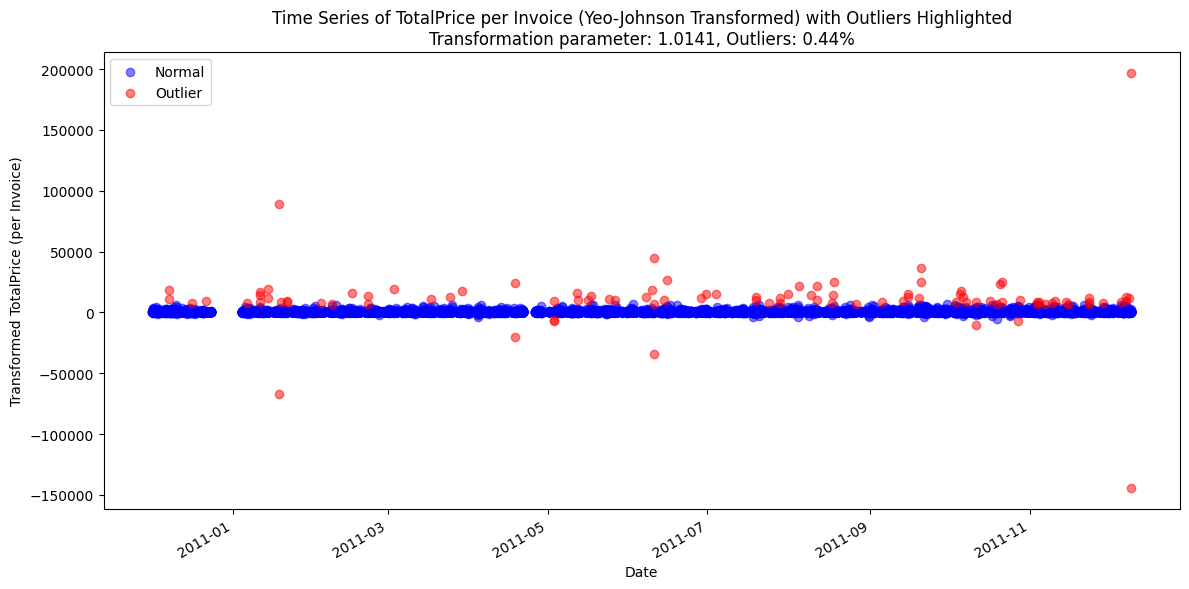

In [126]:
plot_invoice_timeseries_with_outliers(customer_df, 'InvoiceDate', 'TotalPrice', 'CustomerID')

In [71]:
def plot_timeseries_with_outliers(df, date_column, value_column, z_score_threshold=3):
    # Make a copy of the DataFrame
    df = df.copy()
    
    # Sort the DataFrame by date
    df = df.sort_values(date_column)
    
    # Apply Yeo-Johnson transformation to the value column
    transformed_data, lambda_param = stats.yeojohnson(df[value_column])
    df['transformed_value'] = transformed_data
    
    # Calculate Z-scores of the transformed data
    df['z_scores'] = np.abs(stats.zscore(df['transformed_value']))
    
    # Identify outliers
    df['is_outlier'] = df['z_scores'] > z_score_threshold
    
    # Calculate percentage of outliers
    outlier_percentage = (df['is_outlier'].sum() / len(df)) * 100
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot non-outliers
    plt.scatter(df[~df['is_outlier']][date_column], 
                df[~df['is_outlier']]['transformed_value'], 
                c='blue', alpha=0.5, label='Normal')
    
    # Plot outliers
    plt.scatter(df[df['is_outlier']][date_column], 
                df[df['is_outlier']]['transformed_value'], 
                c='red', alpha=0.5, label='Outlier')
    
    plt.xlabel('Date')
    plt.ylabel(f'Transformed {value_column}')
    plt.title(f'Time Series of {value_column} (Yeo-Johnson Transformed) with Outliers Highlighted\n'
              f'Transformation parameter: {lambda_param}, '
              f'Outliers: {outlier_percentage:.2f}%')
    
    plt.legend()
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()


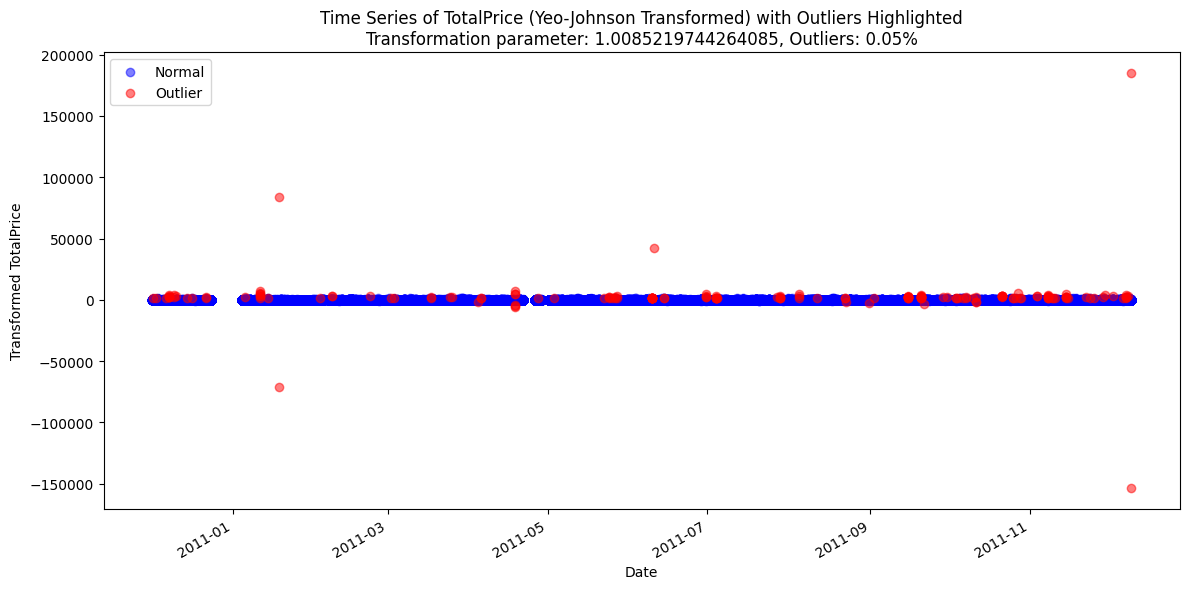

In [72]:
plot_timeseries_with_outliers(product_df, 'InvoiceDate', 'TotalPrice')

In [58]:
def plot_boxplots(df, value_column, z_score_threshold=3):
    # Make a copy of the DataFrame
    df = df.copy()
    
    # Apply Yeo-Johnson transformation to the value column
    transformed_data, lambda_param = stats.yeojohnson(df[value_column])
    df['transformed_value'] = transformed_data
    
    # Calculate Z-scores of the transformed data
    df['z_scores'] = np.abs(stats.zscore(df['transformed_value']))
    
    # Identify outliers
    df['is_outlier'] = df['z_scores'] > z_score_threshold
    
    # Calculate percentage of outliers
    outlier_percentage = (df['is_outlier'].sum() / len(df)) * 100
    
    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot for normal data
    bp1 = ax1.boxplot(df[~df['is_outlier']]['transformed_value'],
                      patch_artist=True)
    bp1['boxes'][0].set_facecolor('lightblue')
    ax1.set_title('Normal Data')
    ax1.set_ylabel(f'Transformed {value_column}')
    
    # Box plot for outliers
    bp2 = ax2.boxplot(df[df['is_outlier']]['transformed_value'],
                      patch_artist=True)
    bp2['boxes'][0].set_facecolor('lightcoral')
    ax2.set_title('Outliers')
    ax2.set_ylabel(f'Transformed {value_column}')
    
    # Overall title
    plt.suptitle(f'Box Plots of {value_column} (Yeo-Johnson Transformed)\n'
              f'Transformation parameter: {lambda_param}, '
              f'Outliers: {outlier_percentage:.2f}%',
              fontsize=16)
    
    plt.tight_layout()
    plt.show()

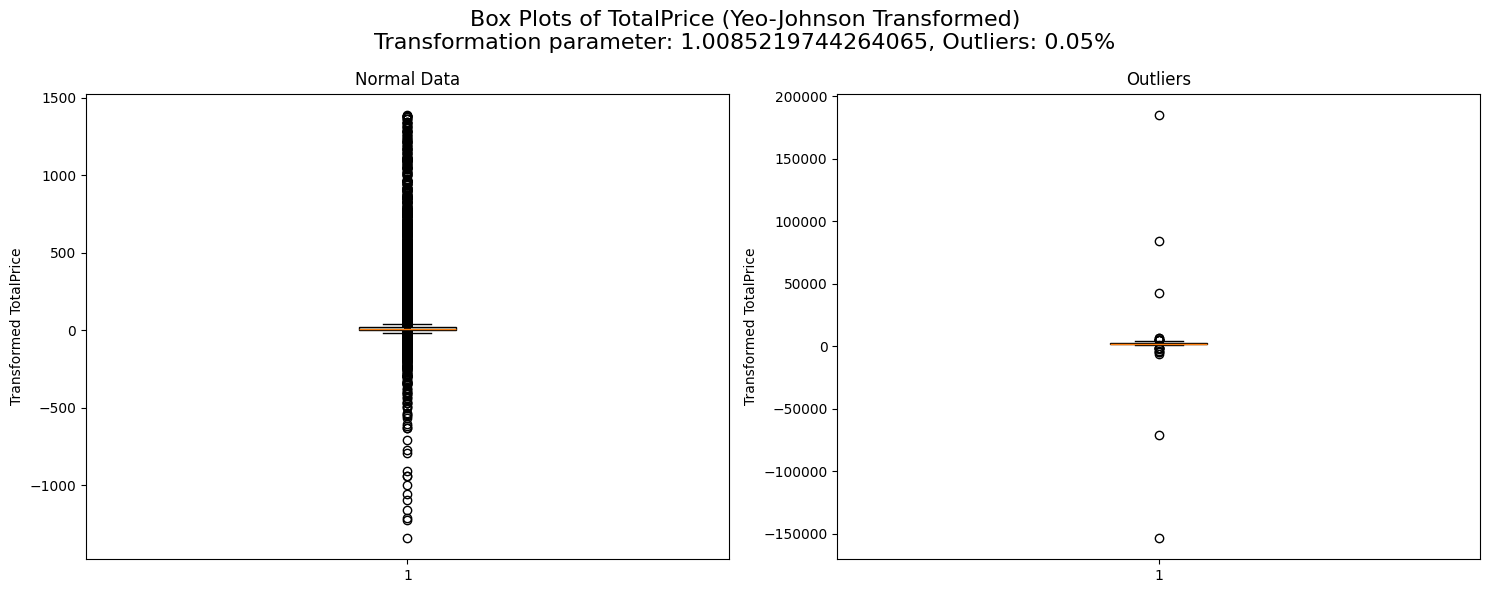

In [59]:
plot_boxplots(product_df, 'TotalPrice')

In [60]:
def plot_histogram_and_density(df, column, bins=10):
    # Make a copy of the DataFrame
    df = df.copy()
    
    # Apply Yeo-Johnson transformation to the column
    transformed_data, lambda_param = stats.yeojohnson(df[column])
    df['transformed_value'] = transformed_data
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle(f'Histogram and Density Plot for {column}')

    # Plot for raw data
    sns.histplot(df[column], kde=True, bins=bins, ax=ax1)
    ax1.set_title('Raw Data')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Frequency')

    # Plot for transformed data
    sns.histplot(df['transformed_value'], kde=True, bins=bins, ax=ax2)
    ax2.set_title('Transformed Data (Yeo-Johnson)')
    ax2.set_xlabel(f'Transformed {column}')
    ax2.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    

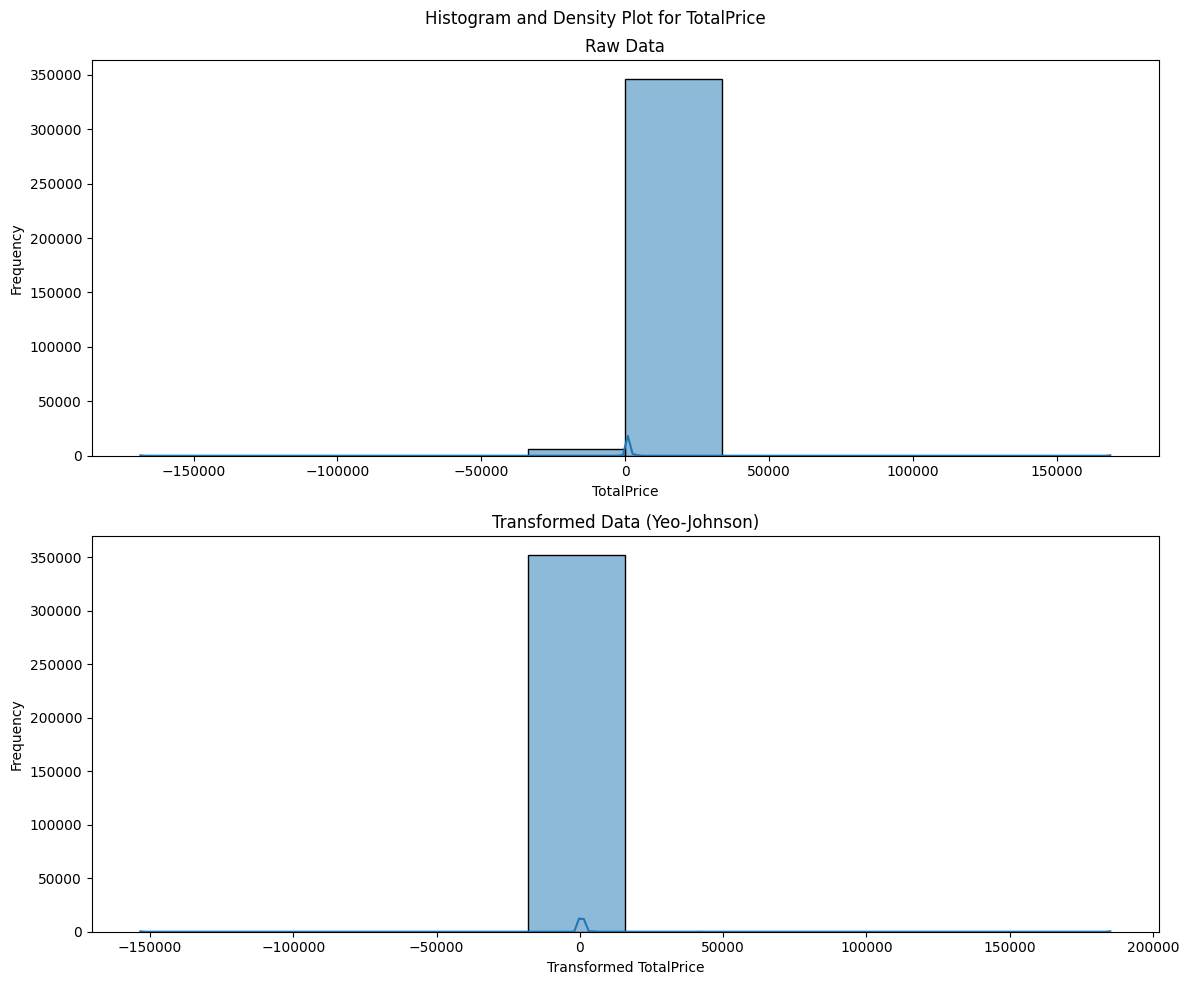

In [61]:
plot_histogram_and_density(product_df, 'TotalPrice')

## Analysis

### Preliminary

In [165]:
print(f"Total Product Sales: {product_df['TotalPrice'].sum():.2f}")

Total Product Sales: 6826497.81


In [63]:
print(f"Total Earnings: {df['TotalPrice'].sum():.2f}")

Total Earnings: 9747747.93


### Average order value per invoice

Sticter invoices dataset produced here using products filter to 

In [73]:
def process_invoices(df):
    
    df_copy = df.copy()
    
    df_copy = remove_null_rows(df_copy)
    
    # Group by CustomerID and InvoiceDate
    grouped = df_copy.groupby(['CustomerID', 'InvoiceDate', 'Country'])
    
    # Calculate the sum of TotalPrice and count of distinct Description values
    result = grouped.agg({
        'TotalPrice': 'sum',
        'Description': 'nunique'
    }).reset_index()
    
    # Rename columns for clarity
    result.columns = ['CustomerID', 'InvoiceDate', 'Country', 'TotalPrice', 'UniqueItemCount']
    
    result = result.sort_values(['CustomerID', 'InvoiceDate', 'TotalPrice'], 
                                ascending=[True, True, False])
    
    return result

Value of invoices analysed with broader dataset, composition of invoices restricted to products only.

In [74]:
invoices_price_df = process_invoices(customer_df)

In [75]:
invoices_products_df = process_invoices(product_df)

In [76]:
print("InvoiceTotalPrice Statistics:")
print(f"Average: {invoices_price_df['TotalPrice'].mean():.2f}")
print(f"Median: {invoices_price_df['TotalPrice'].median():.2f}")
print(f"Minimum: {invoices_price_df['TotalPrice'].min():.2f}")
print(f"Maximum: {invoices_price_df['TotalPrice'].max():.2f}")

print("\nUniqueItemCount Statistics:")
print(f"Average: {invoices_products_df['UniqueItemCount'].mean():.2f}")
print(f"Median: {invoices_products_df['UniqueItemCount'].median():.2f}")
print(f"Minimum: {invoices_products_df['UniqueItemCount'].min()}")
print(f"Maximum: {invoices_products_df['UniqueItemCount'].max()}")

InvoiceTotalPrice Statistics:
Average: 376.69
Median: 243.62
Minimum: -168469.60
Maximum: 168469.60

UniqueItemCount Statistics:
Average: 12.62
Median: 9.00
Minimum: 1
Maximum: 358


### Individual Products

In [68]:
def product_sales_distribution_plot(df):
    # Group by Description and sum TotalPrice
    product_sales = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
    
    # Calculate cumulative sales and percentages
    total_sales = product_sales.sum()
    cumulative_sales = product_sales.cumsum()
    product_percentages = np.arange(1, len(product_sales) + 1) / len(product_sales)
    sales_percentages = cumulative_sales / total_sales

    # Calculate Gini coefficient
    gini = 1 - 2 * np.trapz(sales_percentages, product_percentages)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(product_percentages, sales_percentages, label='Lorenz curve')
    plt.plot([0, 1], [0, 1], 'r--', label='Line of equality')
    plt.xlabel('Cumulative proportion of products')
    plt.ylabel('Cumulative proportion of sales')
    plt.title(f'Sales Distribution (Gini coefficient: {gini:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print some summary statistics
    print(f"Gini coefficient: {gini:.3f}")
    
    print(f"Top 1% of products account for {sales_percentages.iloc[int(0.01*len(sales_percentages))]*100:.1f}% of sales")
    print(f"Top 10% of products account for {sales_percentages.iloc[int(0.1*len(sales_percentages))]*100:.1f}% of sales")
    print(f"Top 20% of products account for {sales_percentages.iloc[int(0.2*len(sales_percentages))]*100:.1f}% of sales")
    
    # Calculate percentage of sales for top 10 products
    top_10_sales = product_sales.head(10).sum()
    top_10_percentage = (top_10_sales / total_sales) * 100
    print(f"Top 10 products account for {top_10_percentage:.1f}% of sales")
    
    # Calculate and print top 10 and bottom 10 grossing products
    product_sales_percentage = product_sales / total_sales * 100
    
    print("\nTop 10 grossing products:")
    top_10 = product_sales.head(10)
    for product, sales in top_10.items():
        percentage = product_sales_percentage[product]
        print(f"{product}: £{sales:.2f} ({percentage:.2f}% of total sales)")
    
    print("\nBottom 10 grossing products:")
    bottom_10 = product_sales_percentage.tail(10)
    for product, sales in bottom_10.items():
        percentage = product_sales_percentage[product]
        print(f"{product}: £{sales:.2f} ({percentage:.2f}% of total sales)")
        
    # Print total number of products
    print(f"\nTotal number of distinct products: {len(product_sales)}")

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_19233/3864377436.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(sales_percentages, product_percentages)


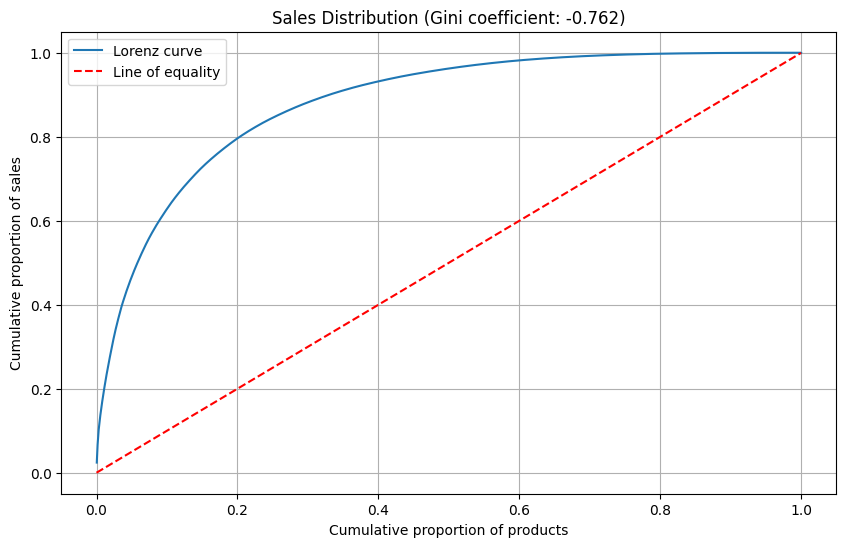

Gini coefficient: -0.762
Top 1% of products account for 19.1% of sales
Top 10% of products account for 62.9% of sales
Top 20% of products account for 79.7% of sales
Top 10 products account for 11.5% of sales

Top 10 grossing products:
REGENCY CAKESTAND 3 TIER: £164762.19 (2.41% of total sales)
WHITE HANGING HEART T-LIGHT HOLDER: £99668.47 (1.46% of total sales)
PARTY BUNTING: £98302.98 (1.44% of total sales)
JUMBO BAG RED RETROSPOT: £92356.03 (1.35% of total sales)
RABBIT NIGHT LIGHT: £66756.59 (0.98% of total sales)
PAPER CHAIN KIT 50'S CHRISTMAS: £63791.94 (0.93% of total sales)
ASSORTED COLOUR BIRD ORNAMENT: £58959.73 (0.86% of total sales)
CHILLI LIGHTS: £53768.06 (0.79% of total sales)
SPOTTY BUNTING: £42065.32 (0.62% of total sales)
JUMBO BAG PINK POLKADOT: £41619.66 (0.61% of total sales)

Bottom 10 grossing products:
FLAMINGO LIGHTS: £-0.00 (-0.00% of total sales)
SWEETHEART KEY CABINET: £-0.00 (-0.00% of total sales)
CREAM SWEETHEART SHELF + HOOKS: £-0.00 (-0.00% of total sale

In [69]:
product_sales_distribution_plot(product_df)

In [70]:
def generate_distinct_colors(n):
    HSV_tuples = [(x*1.0/n, 0.8, 0.9) for x in range(n)]
    RGB_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples)
    return list(RGB_tuples)

def plot_top_5_products_timeseries(df):
    # Group by month and product, sum the TotalPrice
    monthly_sales = df.groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Description'])['TotalPrice'].sum().reset_index()
    
    # For each month, rank products by sales
    monthly_sales['Rank'] = monthly_sales.groupby('InvoiceDate')['TotalPrice'].rank(method='dense', ascending=False)
    
    # Keep only top 5 for each month
    top_5_monthly = monthly_sales[monthly_sales['Rank'] <= 5]
    
    # Pivot the data to have products as columns and rank as values
    pivot_data = top_5_monthly.pivot(index='InvoiceDate', columns='Description', values='Rank')
    
    # Generate distinct colors for each product
    colors = generate_distinct_colors(len(pivot_data.columns))
    
    # Plot
    plt.figure(figsize=(20, 10))
    
    # Keep track of label positions
    label_positions = {}
    
    for i, column in enumerate(pivot_data.columns):
        plt.plot(pivot_data.index, pivot_data[column], marker='o', linestyle='-', label=column, color=colors[i])
        
        # Add product labels at the end of each line
        last_valid_index = pivot_data[column].last_valid_index()
        if last_valid_index:
            last_valid_value = pivot_data[column][last_valid_index]
            
            # Check for overlap and adjust y-position if necessary
            y_pos = last_valid_value
            offset = 0
            while y_pos + offset in label_positions:
                offset += 0.25
            y_pos += offset
            
            label_positions[y_pos] = column
            
            # Split the label into multiple lines
            label_lines = textwrap.wrap(column.lower(), width=10)
            label_text = '\n'.join(label_lines)
            
            plt.annotate(label_text, 
                         xy=(last_valid_index, last_valid_value),
                         xytext=(5, 0),
                         textcoords='offset points', 
                         va='center', 
                         ha='left', 
                         color=colors[i], 
                         fontweight='bold',
                         annotation_clip=False,
                         wrap=True)
    
    plt.title('Top 5 Highest Earning Products Rankings Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rank', fontsize=12)
    plt.xticks(rotation=45)
    
    # Set y-axis limits and ticks
    plt.ylim(6, 0.5)  # Extend the y-axis slightly to accommodate labels
    plt.yticks(range(1, 6))
    
    plt.tight_layout()
    plt.show()

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_19233/234873769.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Description'])['TotalPrice'].sum().reset_index()


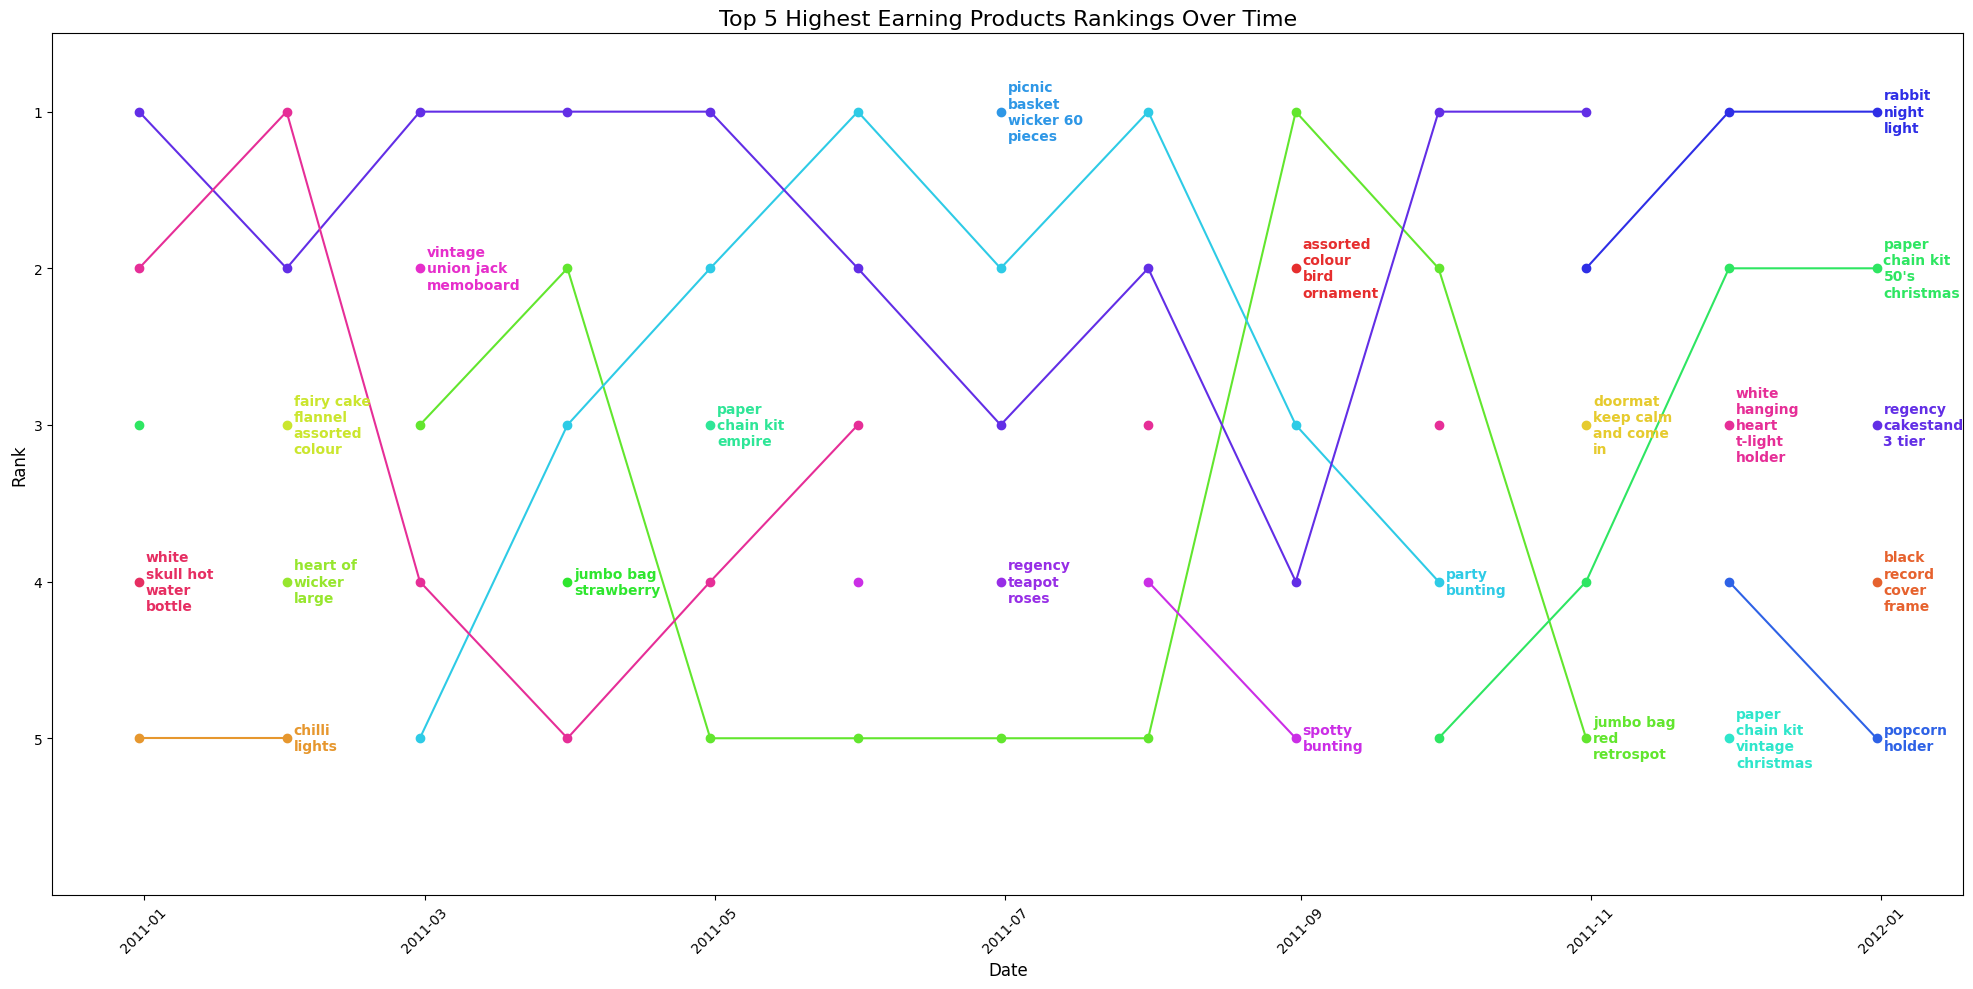

In [71]:
plot_top_5_products_timeseries(product_df)

### Time

Product sales charts printed first, with more inclusive (less studied) pseudo-earnings charts provided underneath each.

In [72]:
def plot_quarterly_sales_and_growth(df, date_column='InvoiceDate', price_column='TotalPrice'):
    # Group by quarter and sum the total price
    quarterly_sales = df.groupby(df[date_column].dt.to_period("Q"))[price_column].sum().reset_index()
    
    # Convert period to timestamp for plotting
    quarterly_sales[date_column] = quarterly_sales[date_column].dt.to_timestamp()
    
    # Calculate quarter-over-quarter growth rate
    quarterly_sales['Growth_Rate'] = quarterly_sales[price_column].pct_change() * 100
    
    # Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax2 = ax1.twinx()
    
    # Plot bar chart on primary y-axis
    bars = ax1.bar(quarterly_sales[date_column], quarterly_sales[price_column], width=60, alpha=0.7, color='skyblue', label='Quarterly Sales')
    
    # Plot growth rate on secondary y-axis
    line = ax2.plot(quarterly_sales[date_column], quarterly_sales['Growth_Rate'], color='green', label='Growth Rate (%)')
    
    # Customize the plot
    ax1.set_title('Quarterly Total Sales and Growth Rate')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Sales', color='blue')
    ax2.set_ylabel('Growth Rate (%)', color='green')
    
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    # Use a tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Calculate statistics
    avg_sales = quarterly_sales[price_column].mean()
    avg_growth = quarterly_sales['Growth_Rate'].mean()
    max_sales = quarterly_sales[price_column].max()
    max_growth = quarterly_sales['Growth_Rate'].max()
    min_sales = quarterly_sales[price_column].min()
    min_growth = quarterly_sales['Growth_Rate'].min()
    
    # Custom function to format quarter
    def format_quarter(date):
        return f"Q{date.quarter} {date.year}"
    
    max_sales_quarter = format_quarter(quarterly_sales.loc[quarterly_sales[price_column].idxmax(), date_column])
    max_growth_quarter = format_quarter(quarterly_sales.loc[quarterly_sales['Growth_Rate'].idxmax(), date_column])
    min_sales_quarter = format_quarter(quarterly_sales.loc[quarterly_sales[price_column].idxmin(), date_column])
    min_growth_quarter = format_quarter(quarterly_sales.loc[quarterly_sales['Growth_Rate'].idxmin(), date_column])
    
    # Print expanded summary statistics
    print(f"Average Quarterly Sales: {avg_sales:.2f}")
    print(f"Average Quarterly Growth Rate: {avg_growth:.2f}%")
    print(f"Highest Quarterly Sales: {max_sales:.2f} ({max_sales_quarter})")
    print(f"Lowest Quarterly Sales: {min_sales:.2f} ({min_sales_quarter})")
    print(f"Highest Quarterly Growth Rate: {max_growth:.2f}% ({max_growth_quarter})")
    print(f"Lowest Quarterly Growth Rate: {min_growth:.2f}% ({min_growth_quarter})")

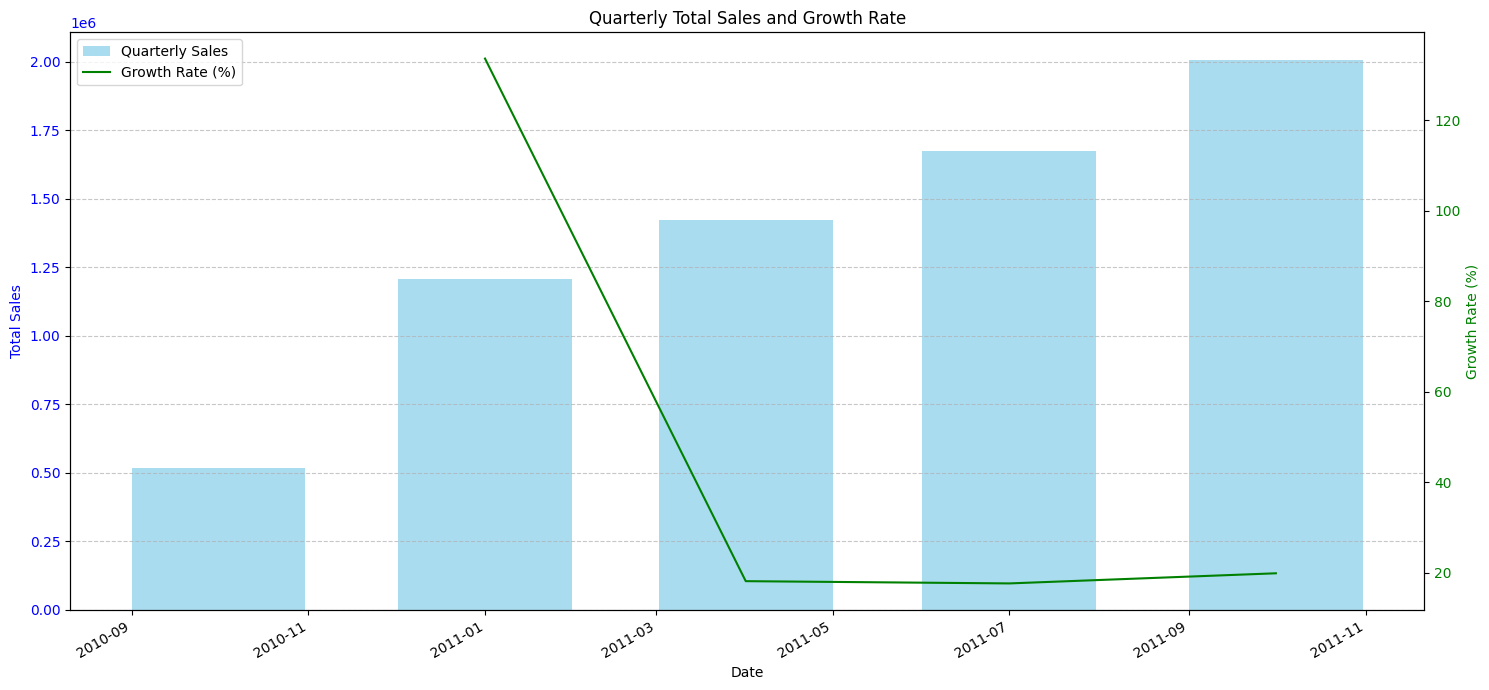

Average Quarterly Sales: 1365299.56
Average Quarterly Growth Rate: 47.28%
Highest Quarterly Sales: 2006527.79 (Q4 2011)
Lowest Quarterly Sales: 516149.09 (Q4 2010)
Highest Quarterly Growth Rate: 133.58% (Q1 2011)
Lowest Quarterly Growth Rate: 17.60% (Q3 2011)


In [73]:
plot_quarterly_sales_and_growth(product_df)

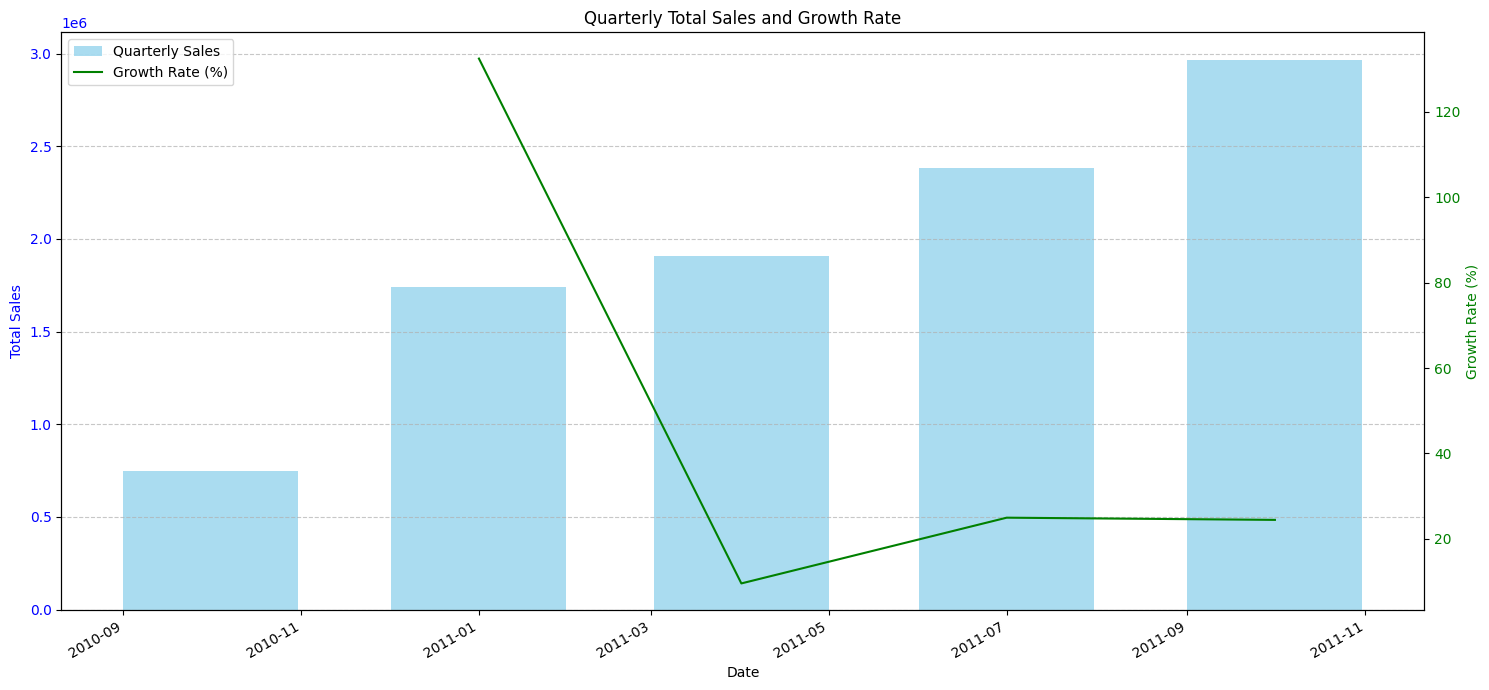

Average Quarterly Sales: 1949549.59
Average Quarterly Growth Rate: 47.86%
Highest Quarterly Sales: 2966128.93 (Q4 2011)
Lowest Quarterly Sales: 748957.02 (Q4 2010)
Highest Quarterly Growth Rate: 132.50% (Q1 2011)
Lowest Quarterly Growth Rate: 9.55% (Q2 2011)


In [74]:
plot_quarterly_sales_and_growth(df)

In [75]:
def plot_quarterly_cumulative_sales_time_series(df):

  # Group by quarter and sum the TotalPrice
  quarterly_sales = df.groupby(df['InvoiceDate'].dt.to_period("Q"))['TotalPrice'].sum().reset_index()

  # Convert the period index to datetime for better plotting
  quarterly_sales['InvoiceDate'] = quarterly_sales['InvoiceDate'].dt.to_timestamp()

  # Calculate cumulative sum
  quarterly_sales['CumulativeSales'] = quarterly_sales['TotalPrice'].cumsum()

  # Create the plots
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

  # Plot 1: Grouped by quarter
  ax1.plot(quarterly_sales['InvoiceDate'], quarterly_sales['TotalPrice'], marker='o')
  ax1.set_title('Quarterly Total Sales (Grouped)')
  ax1.set_xlabel('Date')
  ax1.set_ylabel('Total Sales')
  ax1.grid(True)

  # Plot 2: Cumulative
  ax2.plot(quarterly_sales['InvoiceDate'], quarterly_sales['CumulativeSales'], marker='o', color='r')
  ax2.set_title('Cumulative Quarterly Sales')
  ax2.set_xlabel('Date')
  ax2.set_ylabel('Cumulative Sales')
  ax2.grid(True)

  # Rotate and align the tick labels so they look better
  fig.autofmt_xdate()

  # Use tight layout to ensure everything fits without overlapping
  plt.tight_layout()

  # Show the plots
  plt.show()
  

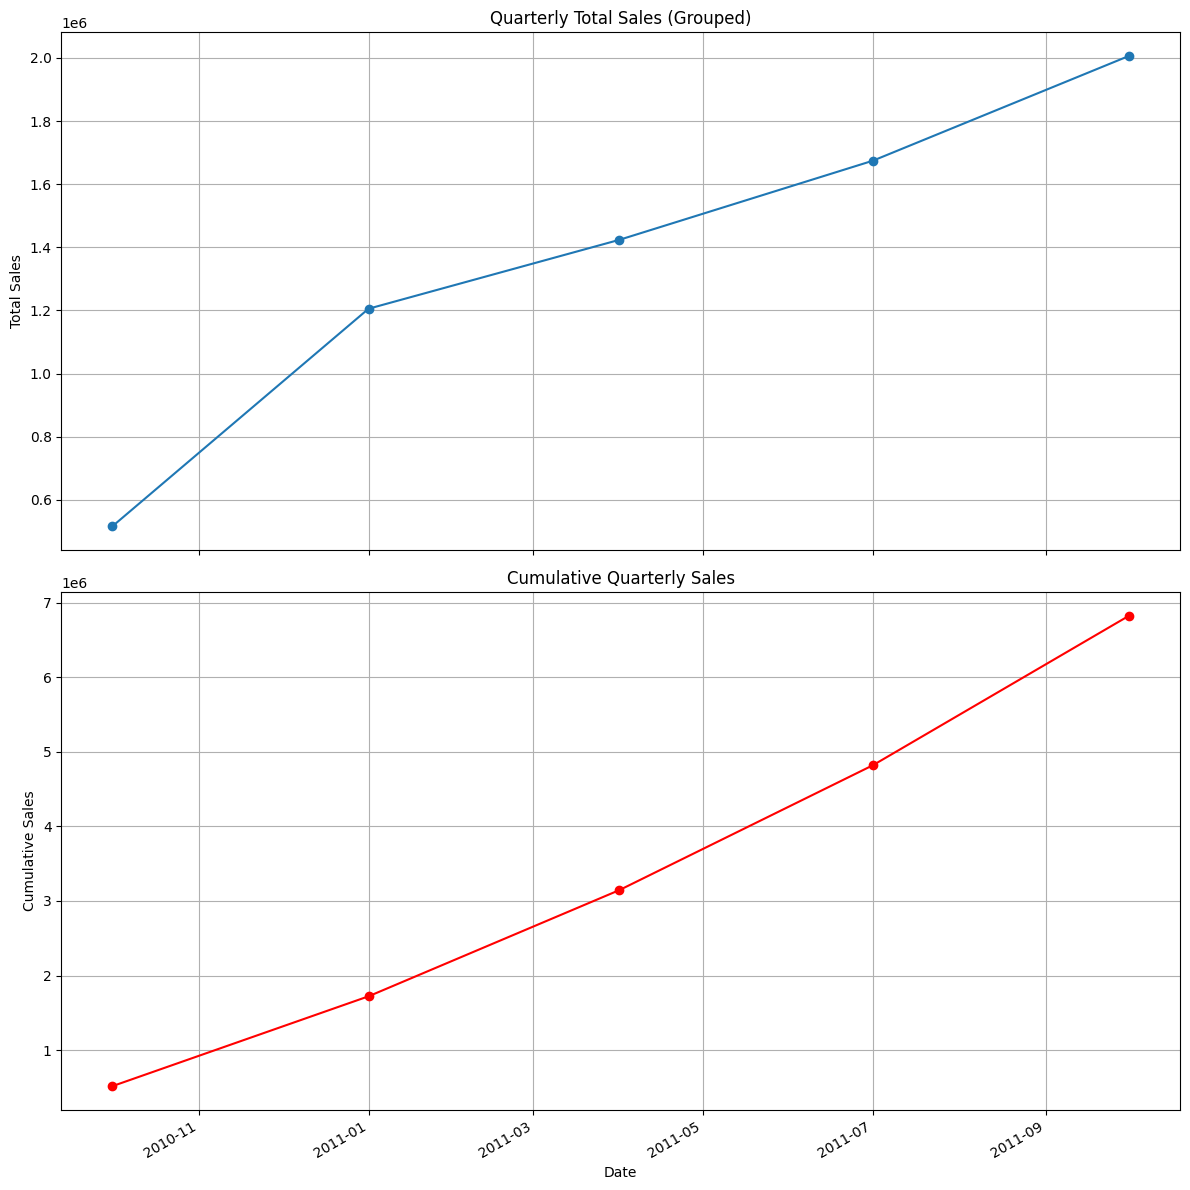

In [76]:
plot_quarterly_cumulative_sales_time_series(product_df)

In [77]:
def plot_monthly_sales_and_growth(df, date_column='InvoiceDate', price_column='TotalPrice'):

    # Group by month and sum the total price
    monthly_sales = df.groupby(df[date_column].dt.to_period("M"))[price_column].sum().reset_index()
    
    # Convert period to timestamp for plotting
    monthly_sales[date_column] = monthly_sales[date_column].dt.to_timestamp()
    
    # Calculate month-over-month growth rate
    monthly_sales['Growth_Rate'] = monthly_sales[price_column].pct_change() * 100
    
    # Create the plot with two y-axes
    fig, ax1 = plt.subplots(figsize=(15, 7))
    ax2 = ax1.twinx()
    
    # Plot bar chart on primary y-axis
    bars = ax1.bar(monthly_sales[date_column], monthly_sales[price_column], width=20, alpha=0.7, color='skyblue', label='Monthly Sales')
    
    # Plot growth rate on secondary y-axis
    line = ax2.plot(monthly_sales[date_column], monthly_sales['Growth_Rate'], color='green', label='Growth Rate (%)')
    
    # Customize the plot
    ax1.set_title('Monthly Total Sales and Growth Rate')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Sales', color='blue')
    ax2.set_ylabel('Growth Rate (%)', color='green')
    
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='green')
    
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')
    
    # Use a tight layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    # Calculate statistics
    avg_sales = monthly_sales[price_column].mean()
    avg_growth = monthly_sales['Growth_Rate'].mean()
    max_sales = monthly_sales[price_column].max()
    max_growth = monthly_sales['Growth_Rate'].max()
    min_sales = monthly_sales[price_column].min()
    min_growth = monthly_sales['Growth_Rate'].min()
    
    max_sales_month = monthly_sales.loc[monthly_sales[price_column].idxmax(), date_column].strftime('%B %Y')
    max_growth_month = monthly_sales.loc[monthly_sales['Growth_Rate'].idxmax(), date_column].strftime('%B %Y')
    min_sales_month = monthly_sales.loc[monthly_sales[price_column].idxmin(), date_column].strftime('%B %Y')
    min_growth_month = monthly_sales.loc[monthly_sales['Growth_Rate'].idxmin(), date_column].strftime('%B %Y')
    
    # Print expanded summary statistics
    print(f"Average Monthly Sales: {avg_sales:.2f}")
    print(f"Average Monthly Growth Rate: {avg_growth:.2f}%")
    print(f"Highest Monthly Sales: {max_sales:.2f} ({max_sales_month})")
    print(f"Lowest Monthly Sales: {min_sales:.2f} ({min_sales_month})")
    print(f"Highest Monthly Growth Rate: {max_growth:.2f}% ({max_growth_month})")
    print(f"Lowest Monthly Growth Rate: {min_growth:.2f}% ({min_growth_month})")

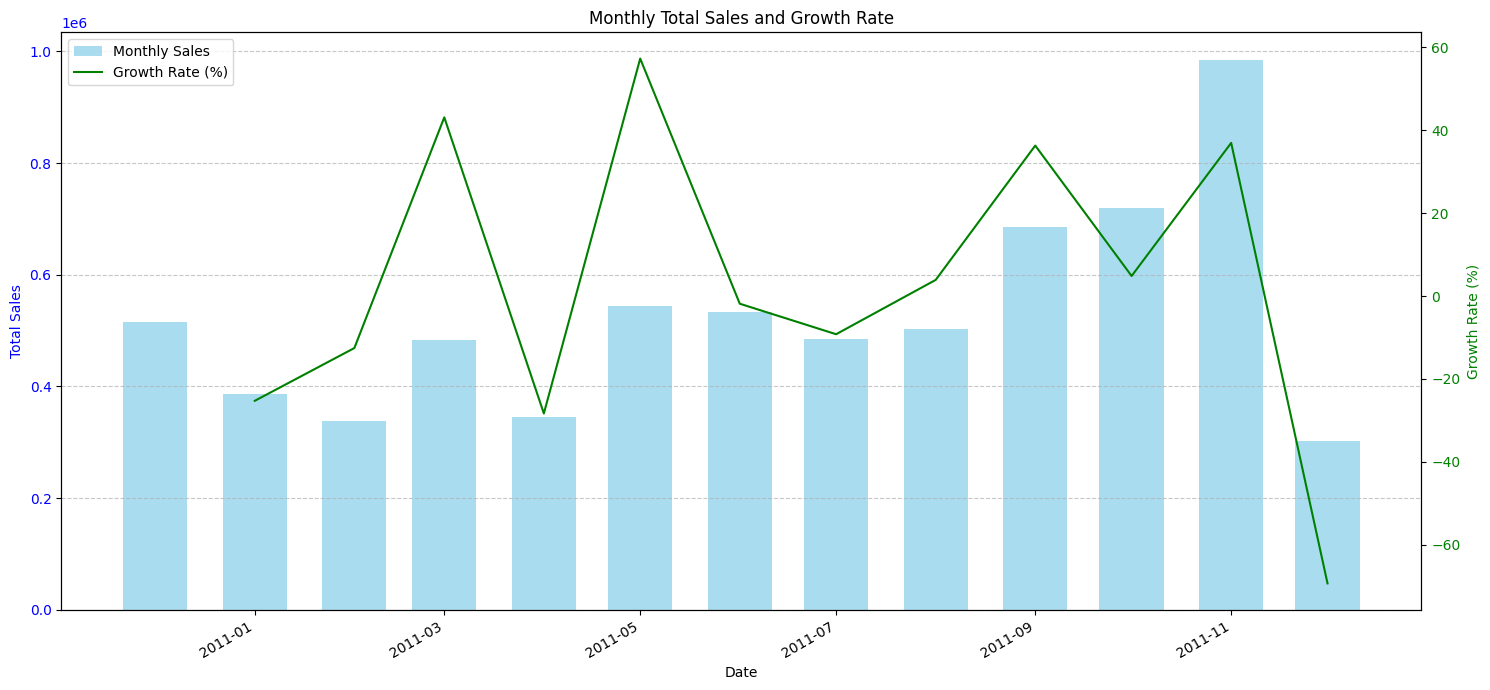

Average Monthly Sales: 525115.22
Average Monthly Growth Rate: 2.98%
Highest Monthly Sales: 984953.82 (November 2011)
Lowest Monthly Sales: 302252.10 (December 2011)
Highest Monthly Growth Rate: 57.26% (May 2011)
Lowest Monthly Growth Rate: -69.31% (December 2011)


In [78]:
plot_monthly_sales_and_growth(product_df)

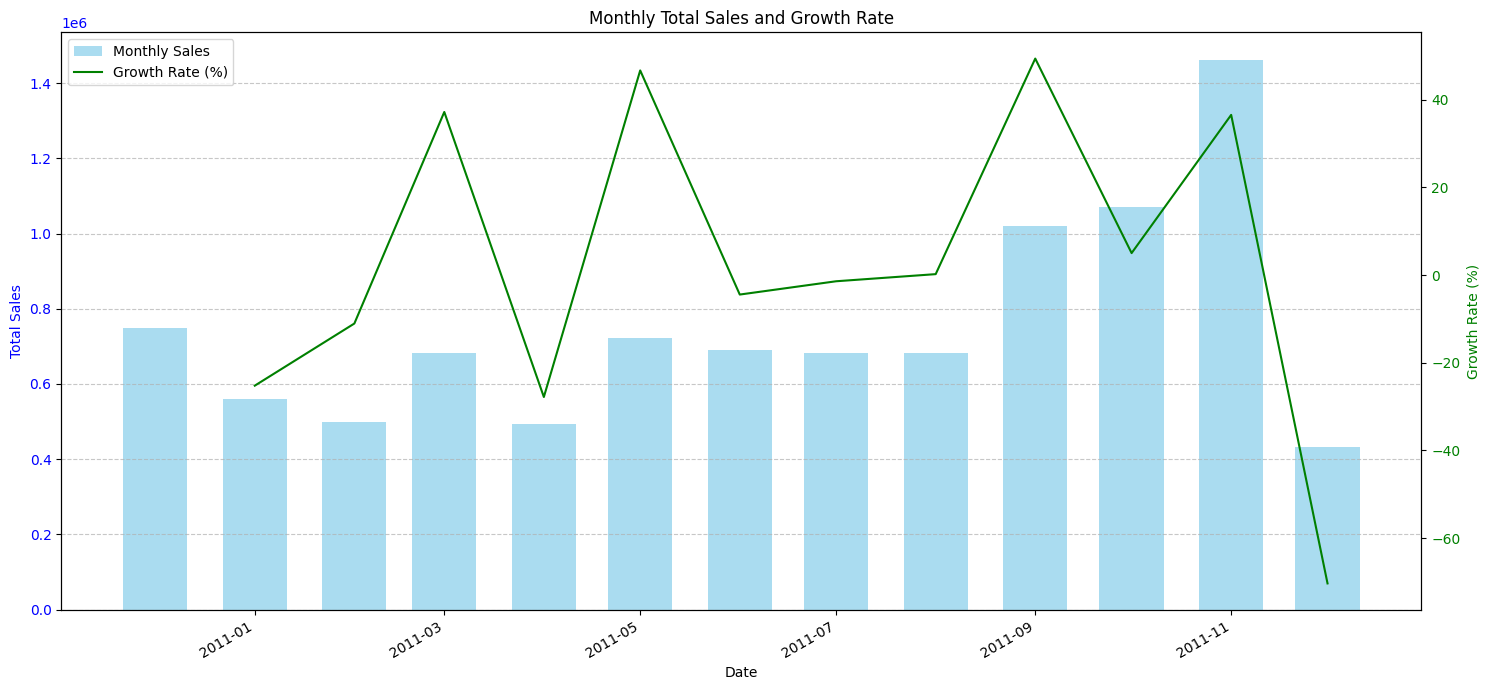

Average Monthly Sales: 749826.76
Average Monthly Growth Rate: 2.89%
Highest Monthly Sales: 1461756.25 (November 2011)
Lowest Monthly Sales: 433668.01 (December 2011)
Highest Monthly Growth Rate: 49.37% (September 2011)
Lowest Monthly Growth Rate: -70.33% (December 2011)


In [79]:
plot_monthly_sales_and_growth(df)

### Time of Day

In [78]:
def plot_hourly_sales(df, country='United Kingdom'):
    
    df_copy = df.copy()
    
    # Filter rows for the specified country
    df_copy = df_copy[df_copy['Country'] == country]
    # df_copy = df_copy[(df_copy['Country'] == country) & (df_copy['TotalPrice'] >= 0)]
    
    # Extract hour from InvoiceDate
    df_copy['Hour'] = df_copy['InvoiceDate'].dt.hour
    
    # Group by hour and sum the TotalPrice
    hourly_sales = df_copy.groupby('Hour')['TotalPrice'].sum().reset_index()
    
    # Sort by Hour to ensure correct order
    hourly_sales = hourly_sales.sort_values('Hour')
    
    # Create the bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(hourly_sales['Hour'], hourly_sales['TotalPrice'], color='skyblue', edgecolor='navy')
    plt.title(f'Total Sales by Hour of Day - {country}', fontsize=16)
    plt.xlabel('Hour of Day', fontsize=12)
    plt.ylabel('Total Sales', fontsize=12)
    plt.xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on top of each bar
    for i, v in enumerate(hourly_sales['TotalPrice']):
        plt.text(hourly_sales['Hour'][i], v, f'£{v:,.0f}', ha='center', va='bottom')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


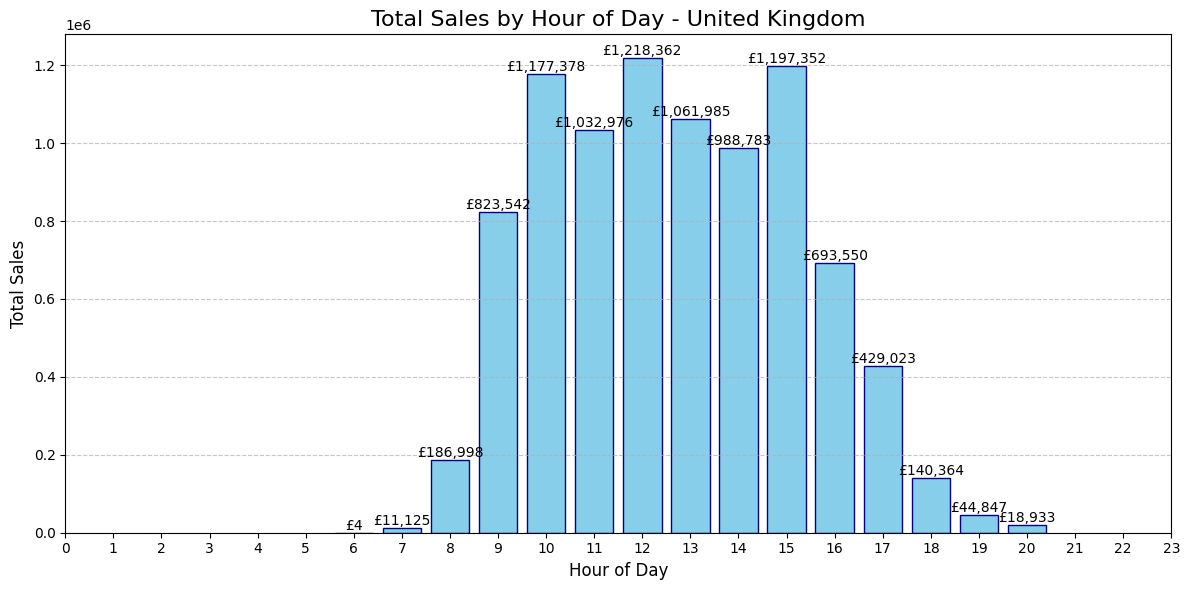

In [87]:
plot_hourly_sales(df[df['TotalPrice'] >= 0])

Negatives removed. Removes bias of potential product return/manual input invoices timed differently to original invoices; at potential cost of overstating sales corrected for within the same invoice/hour.

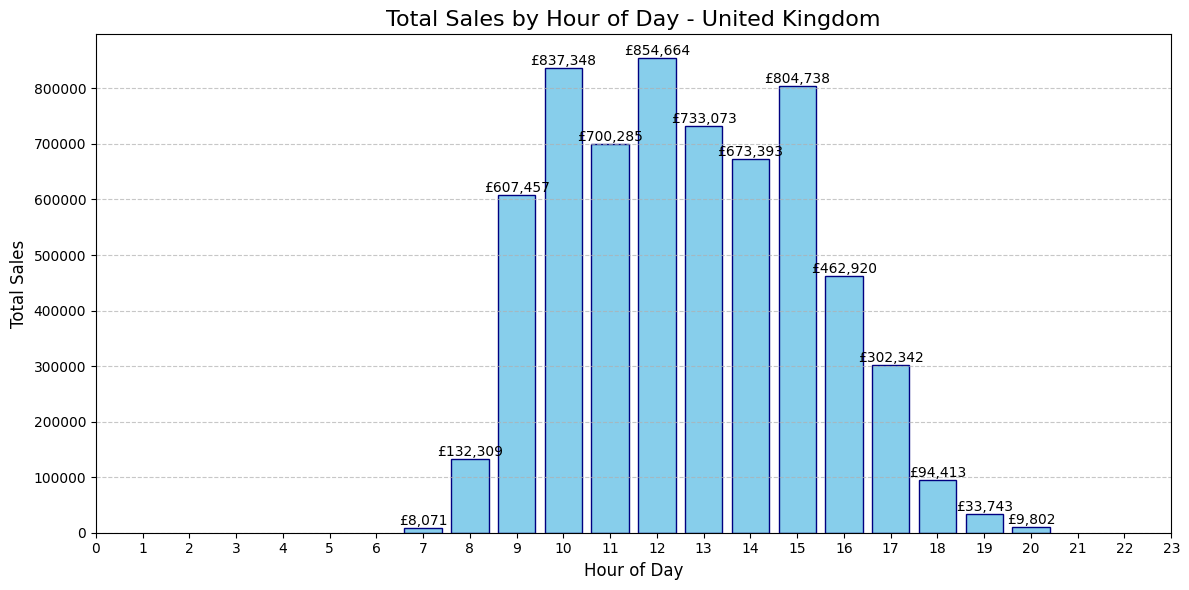

In [80]:
plot_hourly_sales(product_df[product_df['TotalPrice'] >= 0])

While some sales removed, and some potential erroneous sales correction times unaddressed; wider sales costs/earnings attributable to customers included through use of invoice data.

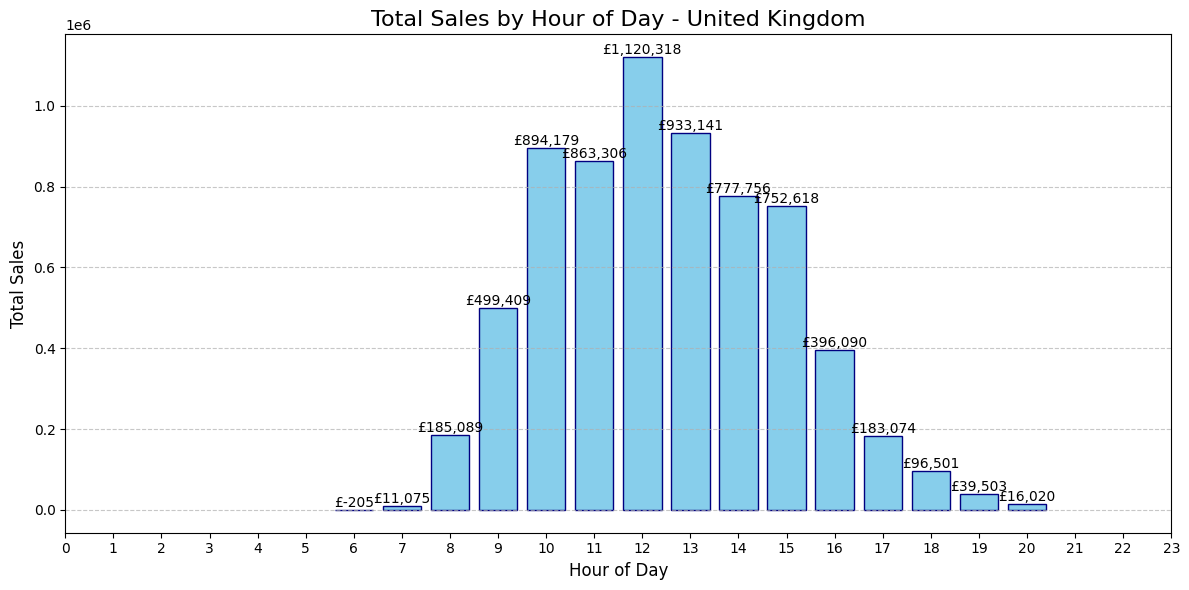

In [81]:
plot_hourly_sales(customer_df)

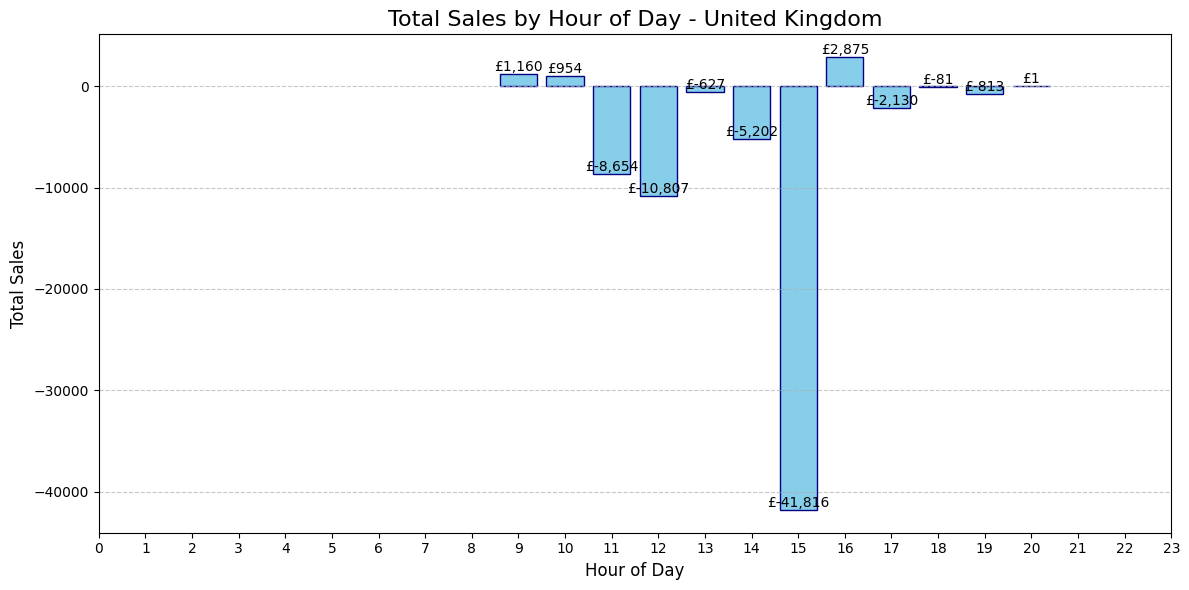

In [82]:
plot_hourly_sales(df[df['Description'] == 'Manual'])

### Countries

Countries renamed to work with map plotting library.

In [88]:
print(f"Number of rows where Country is 'EIRE' or 'RSA': {product_df['Country'].isin(['EIRE', 'RSA']).sum()}")

Number of rows where Country is 'EIRE' or 'RSA': 0


In [89]:
def create_sales_map(df, nb_class=7):
    # Group by Country and sum TotalPrices
    country_sales = df.groupby('Country')['TotalPrice'].sum().reset_index()
    country_sales.columns = ['Country', 'TotalSales']

    # Function to calculate Jenks natural breaks
    def get_jenks_breaks(data, nb_class):
        return jenkspy.jenks_breaks(data, n_classes=nb_class)

    # Calculate Jenks natural breaks
    sales_values = country_sales['TotalSales'].values
    jenks_breaks = get_jenks_breaks(sales_values, nb_class)

    # Classify each country's sales data into the corresponding Jenks interval
    def classify_jenks(sales_value, breaks):
        for i in range(len(breaks) - 1):
            if breaks[i] <= sales_value <= breaks[i + 1]:
                return i
        return len(breaks) - 2  # If not found, return the highest class

    # Apply Jenks classification to each country's sales value
    country_sales['JenksClass'] = country_sales['TotalSales'].apply(lambda x: classify_jenks(x, jenks_breaks))

    # Create a custom color scale based on the number of classes
    colors = ['#FFEDA0', '#FED976', '#FEB24C', '#FD8D3C', '#FC4E2A', '#E31A1C', '#BD0026']
    color_scale = []
    for i in range(len(jenks_breaks) - 1):
        color_scale.append([i / (len(jenks_breaks) - 1), colors[i]])
    color_scale.append([1.0, colors[-1]])  # Add the last color

    # Create the Choropleth map
    fig = go.Figure(data=go.Choropleth(
        locations = country_sales['Country'],
        z = country_sales['JenksClass'],
        locationmode = 'country names',
        colorscale = color_scale,
        colorbar_title = "Total Sales",
        zmin = 0,
        zmax = len(jenks_breaks) - 2,
        marker_line_color='darkgray',
        marker_line_width=0.5,
    ))

    # Update the layout with improved map fitting
    fig.update_layout(
        title_text = 'Total Sales by Country (Jenks Natural Breaks)',
        geo = dict(
            showframe = False,
            showcoastlines = True,
            projection_type = 'equirectangular',
            lataxis_range = [-60, 90],  # Adjust latitude range
            lonaxis_range = [-180, 180],  # Adjust longitude range
            domain = dict(x=[0, 1], y=[0, 1])  # Make the map take up the entire plot area
        ),
        width = 1000,  # Set a fixed width
        height = 600,  # Set a fixed height
        margin = dict(l=0, r=0, t=50, b=0)  # Reduce margins
    )

    # Add a source annotation
    fig.add_annotation(
        x=0.02,
        y=0.02,
        xref='paper',
        yref='paper',
        showarrow=False,
        font=dict(size=10),
        align='left',
        bgcolor='rgba(255, 255, 255, 0.8)',
        bordercolor='rgba(0, 0, 0, 0.3)',
        borderwidth=1,
        borderpad=4
    )

    # Show the map
    fig.show()

    # Display Jenks breaks
    print("\nJenks Natural Breaks:")
    for i, break_value in enumerate(jenks_breaks):
        print(f"Class {i+1}: {break_value:.2f}")

    # Display top 10 countries and their sales for reference
    print("\nTop 10 Countries by Total Sales:")
    print(country_sales.nlargest(10, 'TotalSales').to_string(index=False))

    # Calculate and display some statistics
    total_global_sales = country_sales['TotalSales'].sum()
    print(f"\nTotal global sales: {total_global_sales:.2f}")

    top_5_sales = country_sales.nlargest(5, 'TotalSales')['TotalSales'].sum()
    print(f"Percentage of sales from top 5 countries: {(top_5_sales / total_global_sales) * 100:.2f}%")

    # Count countries with sales
    countries_with_sales = (country_sales['TotalSales'] > 0).sum()
    print(f"Number of countries with sales: {countries_with_sales}")

In [90]:
create_sales_map(df)


Jenks Natural Breaks:
Class 1: 131.17
Class 2: 10154.32
Class 3: 29367.02
Class 4: 56385.35
Class 5: 137077.27
Class 6: 221698.21
Class 7: 284661.54
Class 8: 8187806.36

Top 10 Countries by Total Sales:
       Country  TotalSales  JenksClass
United Kingdom 8187806.364           6
   Netherlands  284661.540           5
       Ireland  263276.820           5
       Germany  221698.210           4
        France  197403.900           4
     Australia  137077.270           3
   Switzerland   56385.350           2
         Spain   54774.580           2
       Belgium   40910.960           2
        Sweden   36595.910           2

Total global sales: 9747747.93
Percentage of sales from top 5 countries: 93.92%
Number of countries with sales: 38


In [87]:
create_sales_map(invoices_price_df)


Jenks Natural Breaks:
Class 1: 131.17
Class 2: 10154.32
Class 3: 29059.81
Class 4: 55739.40
Class 5: 137077.27
Class 6: 221698.21
Class 7: 284661.54
Class 8: 6767873.39

Top 10 Countries by Total Sales:
       Country  TotalSales  JenksClass
United Kingdom 6767873.394           6
   Netherlands  284661.540           5
       Ireland  250285.220           5
       Germany  221698.210           4
        France  196712.840           4
     Australia  137077.270           3
   Switzerland   55739.400           2
         Spain   54774.580           2
       Belgium   40910.960           2
        Sweden   36595.910           2

Total global sales: 8300065.81
Percentage of sales from top 5 countries: 93.03%
Number of countries with sales: 37


In [91]:
def plot_top_10_countries_sales(df):
    # Exclude 'United Kingdom' and group by Country, summing TotalPrice
    country_sales = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
    
    # Get the top 10 countries
    top_10_countries = country_sales.head(10)
    
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    top_10_countries.plot(kind='bar')
    
    # Customize the plot
    plt.title('Top 10 Countries by Total Sales (Excluding UK)')
    plt.xlabel('Country')
    plt.ylabel('Total Sales')
    plt.xticks(rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for i, v in enumerate(top_10_countries):
        plt.text(i, v, f'£{v:,.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

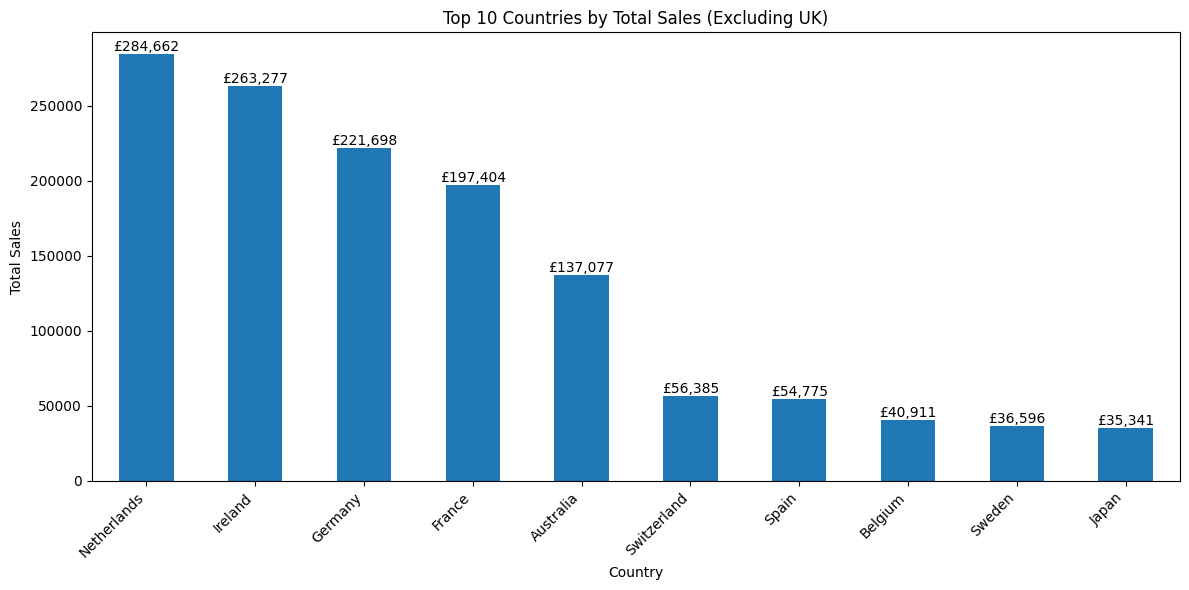

In [95]:
plot_top_10_countries_sales(df)

In [93]:
def calculate_top_11_countries_sales_percentage(df):
    # Group by Country, summing TotalPrice
    country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
    
    # Get the top 11 countries
    top_11_countries = country_sales.head(11)
    
    # Calculate total sales across all countries
    total_sales = country_sales.sum()
    
    # Calculate percentage for each country
    top_11_percentages = (top_11_countries / total_sales * 100).round(2)
    
    # Create a DataFrame with country names, sales values, and percentages
    result_df = pd.DataFrame({
        'Country': top_11_percentages.index,
        'Total Sales': top_11_countries.values,
        'Percentage of Total Sales': top_11_percentages.values
    })
    
    # Calculate the sum of percentages for the top 11 countries
    total_percentage = result_df['Percentage of Total Sales'].sum().round(2)
    
    # Add a row for the total
    result_df.loc[len(result_df)] = ['Total (Top 11)', result_df['Total Sales'].sum(), total_percentage]
    
    return result_df

In [96]:
display(calculate_top_11_countries_sales_percentage(df))

,Country,Total Sales,Percentage of Total Sales
0,United Kingdom,8187806.364,84.00
1,Netherlands,284661.540,2.92
2,Ireland,263276.820,2.70
3,Germany,221698.210,2.27
4,France,197403.900,2.03
5,Australia,137077.270,1.41
6,Switzerland,56385.350,0.58
7,Spain,54774.580,0.56
8,Belgium,40910.960,0.42
9,Sweden,36595.910,0.38


In [97]:
def plot_uk_vs_others(df):
    df_copy = df.copy()
    
    # Set the 'InvoiceDate' as the index
    df_copy.set_index('InvoiceDate', inplace=True)
    
    # Create a new column 'is_uk' to differentiate UK from other countries
    df_copy['is_uk'] = df_copy['Country'] == 'United Kingdom'
    
    # Group by month and 'is_uk', then sum the TotalPrice
    monthly_data = df_copy.groupby([pd.Grouper(freq='M'), 'is_uk'])['TotalPrice'].sum().unstack()
    
    # Rename columns for clarity
    monthly_data.columns = ['Other Countries', 'United Kingdom']
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    monthly_data.plot(kind='line', ax=plt.gca())
    
    plt.title('Monthly Total Price: UK vs Other Countries')
    plt.xlabel('Date')
    plt.ylabel('Total Price')
    plt.legend(title='Country')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_53634/2590939478.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



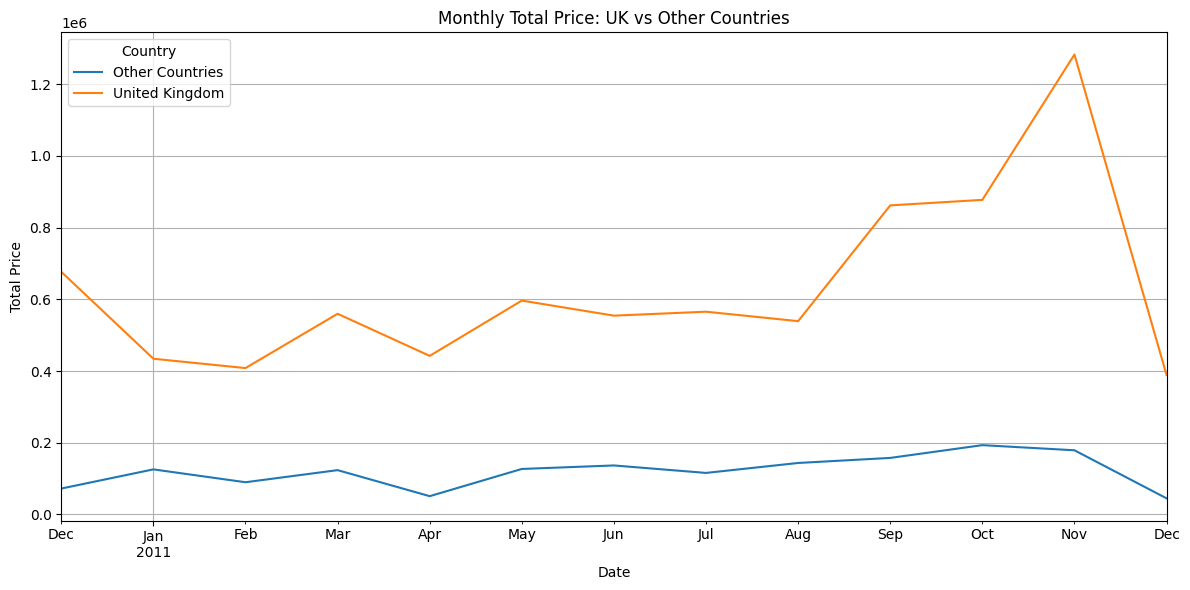

In [98]:
plot_uk_vs_others(df)

In [99]:
def plot_uk_vs_others_separate(df):
    df_copy = df.copy()
    
    # Set the 'InvoiceDate' as the index
    df_copy.set_index('InvoiceDate', inplace=True)
    
    # Create a new column 'is_uk' to differentiate UK from other countries
    df_copy['is_uk'] = df_copy['Country'] == 'United Kingdom'
    
    # Group by month and 'is_uk', then sum the TotalPrice
    monthly_data = df_copy.groupby([pd.Grouper(freq='M'), 'is_uk'])['TotalPrice'].sum().unstack()
    
    # Rename columns for clarity
    monthly_data.columns = ['Other Countries', 'United Kingdom']
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot for United Kingdom
    monthly_data['United Kingdom'].plot(kind='line', ax=ax1, color='blue')
    ax1.set_title('Monthly Total Price: United Kingdom')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Price')
    ax1.grid(True)
    
    # Plot for Other Countries
    monthly_data['Other Countries'].plot(kind='line', ax=ax2, color='green')
    ax2.set_title('Monthly Total Price: Other Countries')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Total Price')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_53634/518875359.py:11: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



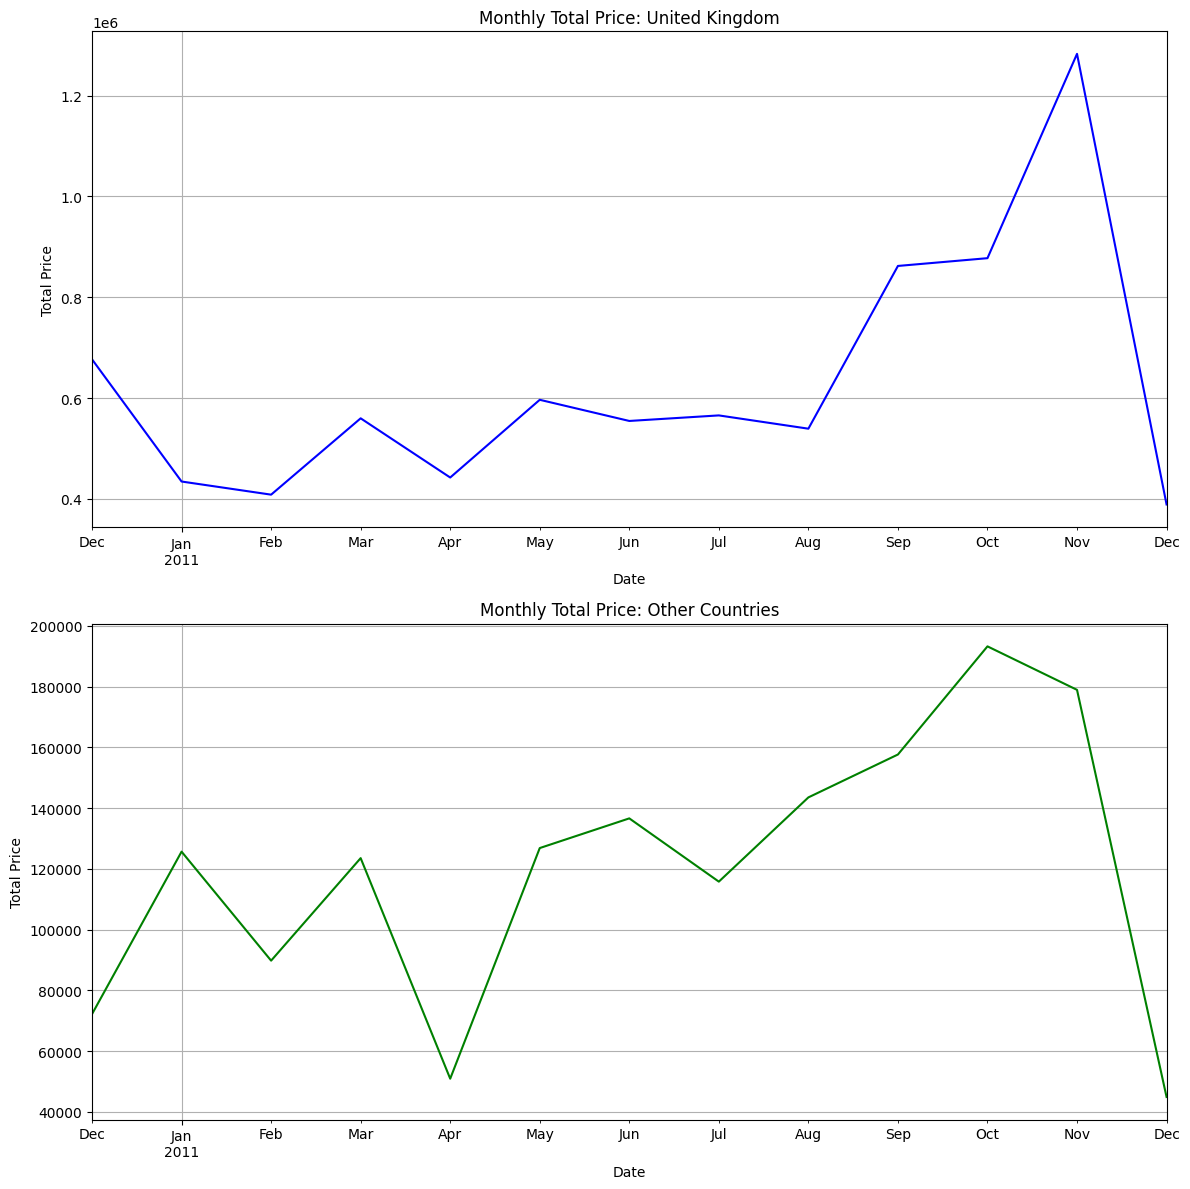

In [100]:
plot_uk_vs_others_separate(df)

In [101]:
def plot_top_10_countries_quarterly_sales(df):
    
    # Exclude UK and get top 10 countries by total sales
    top_10_countries = df[df['Country'] != 'United Kingdom'].groupby('Country')['TotalPrice'].sum().nlargest(10).index
    
    # Filter dataframe for top 10 countries
    df_top_10 = df[df['Country'].isin(top_10_countries)]
    
    # Group by country and quarterly, sum the total price
    quarterly_sales = df_top_10.groupby([df_top_10['Country'], df_top_10['InvoiceDate'].dt.to_period('Q')])['TotalPrice'].sum().unstack(level=0)
    
    # Plot the time series
    plt.figure(figsize=(15, 8))
    for country in quarterly_sales.columns:
        plt.plot(quarterly_sales.index.astype(str), quarterly_sales[country], label=country, marker='o')
    
    plt.title('Quarterly Sales for Top 10 Countries (Excluding UK)')
    plt.xlabel('Quarter')
    plt.ylabel('Total Sales')
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

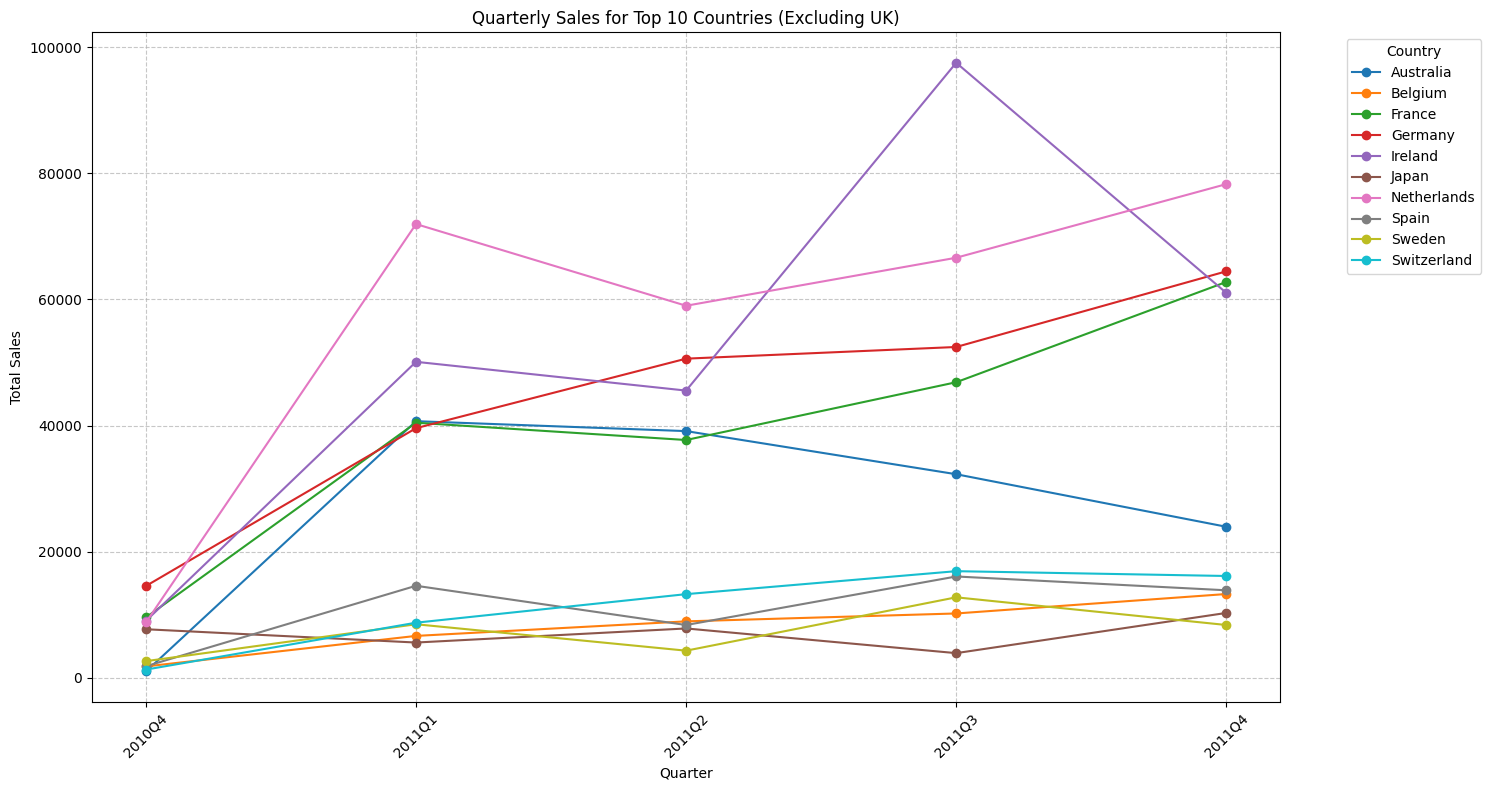

In [102]:
plot_top_10_countries_quarterly_sales(df)

In [103]:
def plot_top_5_countries_rankings_monthly(df):
    
    # Group by month and country, sum the TotalPrice
    monthly_sales = df[df['Country'] != 'United Kingdom'].groupby([pd.Grouper(key='InvoiceDate', freq='M'), 'Country'])['TotalPrice'].sum().reset_index()
    
    # For each month, rank countries by sales
    monthly_sales['Rank'] = monthly_sales.groupby('InvoiceDate')['TotalPrice'].rank(method='dense', ascending=False)
    
    # Keep only top 5 for each month
    top_5_monthly = monthly_sales[monthly_sales['Rank'] <= 5]
    
    # Pivot the data to have countries as columns and rank as values
    pivot_data = top_5_monthly.pivot(index='InvoiceDate', columns='Country', values='Rank')
    
    # Plot
    plt.figure(figsize=(15, 8))
    for column in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[column], marker='o', linestyle='-', label=column)
    
    plt.title('Top 5 Countries by Sales Rankings (Monthly)')
    plt.xlabel('Month')
    plt.ylabel('Rank')
    plt.xticks(rotation=45, ha='right')
    
    # Set y-axis limits and ticks
    plt.ylim(5.5, 0.5)  # Reverse the y-axis
    plt.yticks(range(1, 6))
    
    # Add legend outside of the plot
    plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

def plot_top_5_countries_rankings_quarterly(df):
    
    # Group by quarter and country, sum the TotalPrice
    quarterly_sales = df[df['Country'] != 'United Kingdom'].groupby([pd.Grouper(key='InvoiceDate', freq='Q'), 'Country'])['TotalPrice'].sum().reset_index()
    
    # For each quarter, rank countries by sales
    quarterly_sales['Rank'] = quarterly_sales.groupby('InvoiceDate')['TotalPrice'].rank(method='dense', ascending=False)
    
    # Keep only top 5 for each quarter
    top_5_quarterly = quarterly_sales[quarterly_sales['Rank'] <= 5]
    
    # Pivot the data to have countries as columns and rank as values
    pivot_data = top_5_quarterly.pivot(index='InvoiceDate', columns='Country', values='Rank')
    
    # Plot
    plt.figure(figsize=(15, 8))
    for column in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[column], marker='o', linestyle='-', label=column)
    
    plt.title('Top 5 Countries by Sales Rankings (Quarterly)')
    plt.xlabel('Quarter')
    plt.ylabel('Rank')
    
    # Format x-axis labels to show quarters
    plt.xticks(pivot_data.index, [f'Q{d.quarter} {d.year}' for d in pivot_data.index], rotation=45, ha='right')
    
    # Set y-axis limits and ticks
    plt.ylim(5.5, 0.5)  # Reverse the y-axis
    plt.yticks(range(1, 6))
    
    # Add legend outside of the plot
    plt.legend(title='Countries', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_53634/1534796271.py:38: FutureWarning:

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.



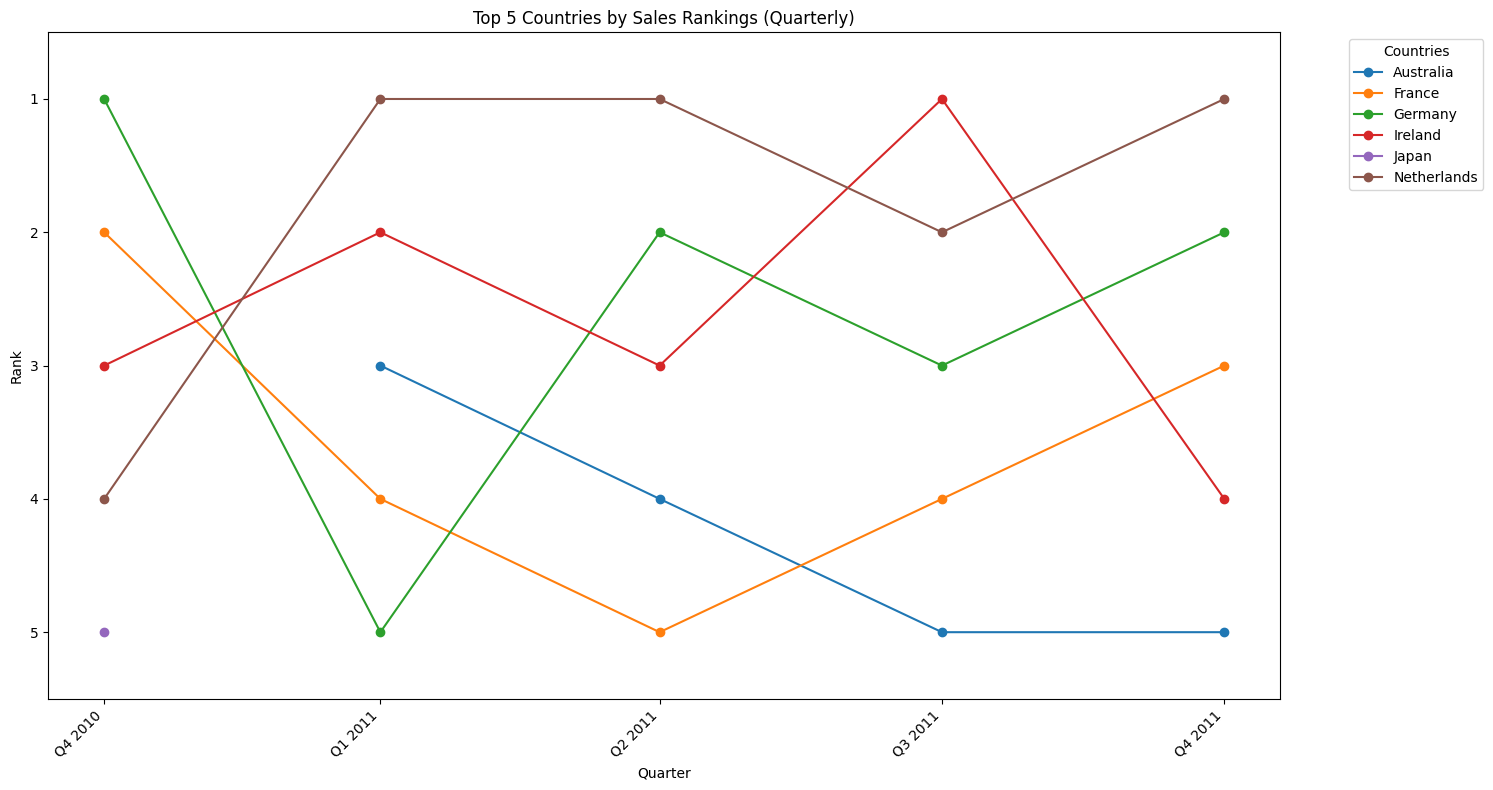

In [104]:
plot_top_5_countries_rankings_quarterly(df)

### Customers

Non-product customer data included for broader sales figures; excluded for analysis emphasising products.

In [105]:
def customer_sales_distribution_plot(df):
    # Group by CustomerID and sum TotalPrice
    customer_sales = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)
    
    # Calculate cumulative sales and percentages
    total_sales = customer_sales.sum()
    cumulative_sales = customer_sales.cumsum()
    customer_percentages = np.arange(1, len(customer_sales) + 1) / len(customer_sales)
    sales_percentages = cumulative_sales / total_sales

    # Calculate Gini coefficient
    gini = 1 - 2 * np.trapz(sales_percentages, customer_percentages)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(customer_percentages, sales_percentages, label='Lorenz curve')
    plt.plot([0, 1], [0, 1], 'r--', label='Line of equality')
    plt.xlabel('Cumulative proportion of customers')
    plt.ylabel('Cumulative proportion of sales')
    plt.title(f'Sales Distribution (Gini coefficient: {gini:.3f})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print some summary statistics
    print(f"Gini coefficient: {gini:.3f}")
    
    print(f"Top 1% of customers account for {sales_percentages.iloc[int(0.01*len(sales_percentages))]*100:.1f}% of sales")
    print(f"Top 10% of customers account for {sales_percentages.iloc[int(0.1*len(sales_percentages))]*100:.1f}% of sales")
    print(f"Top 20% of customers account for {sales_percentages.iloc[int(0.2*len(sales_percentages))]*100:.1f}% of sales")
    
    # Calculate percentage of sales for top 10 customers
    top_10_sales = customer_sales.head(10).sum()
    top_10_percentage = (top_10_sales / total_sales) * 100
    print(f"Top 10 customers account for {top_10_percentage:.1f}% of sales")
    
    # Calculate and print top 10 and bottom 10 grossing customers
    customer_sales_percentage = customer_sales / total_sales * 100
    
    print("\nTop 10 spending customers:")
    top_10 = customer_sales.head(10)
    for rank, (customer, sales) in enumerate(top_10.items(), 1):
        percentage = customer_sales_percentage[customer]
        print(f"{rank}: £{sales:.2f} ({percentage:.2f}% of total sales)")
    
    print("\nBottom 10 grossing customers:")
    bottom_10 = customer_sales.tail(10)
    total_customers = len(customer_sales)
    for rank, (customer, sales) in enumerate(bottom_10.items(), 1):
        percentage = customer_sales_percentage[customer]
        print(f"{total_customers - 10 + rank}: £{sales:.2f} ({percentage:.2f}% of total sales)")
        
    # Print total number of customers
    print(f"\nTotal number of distinct customers: {len(customer_sales)}")

/var/folders/3c/9y2pkm8d0sq9y18zb5lb3kj40000gn/T/ipykernel_53634/1344781493.py:12: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



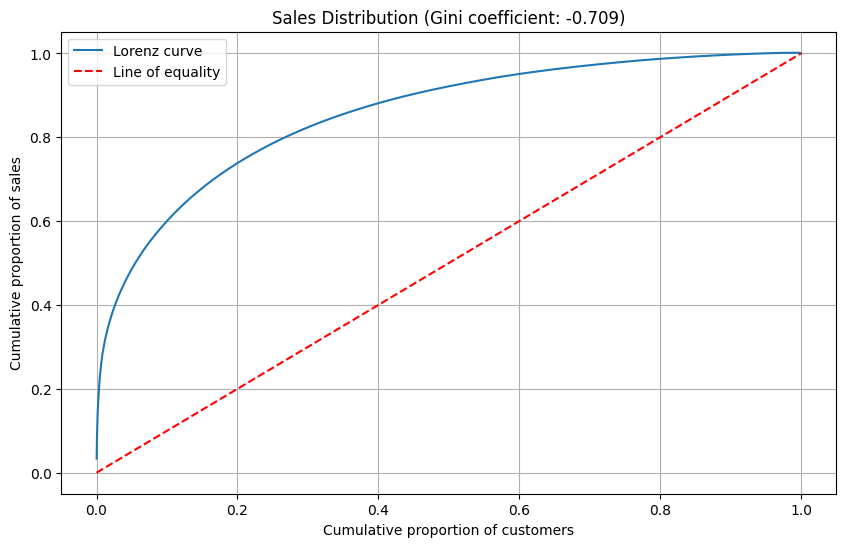

Gini coefficient: -0.709
Top 1% of customers account for 29.9% of sales
Top 10% of customers account for 60.0% of sales
Top 20% of customers account for 73.8% of sales
Top 10 customers account for 16.5% of sales

Top 10 spending customers:
1: £279489.02 (3.37% of total sales)
2: £256438.49 (3.09% of total sales)
3: £187482.17 (2.26% of total sales)
4: £132572.62 (1.60% of total sales)
5: £123725.45 (1.49% of total sales)
6: £113384.14 (1.37% of total sales)
7: £88125.38 (1.06% of total sales)
8: £65892.08 (0.79% of total sales)
9: £62653.10 (0.75% of total sales)
10: £59419.34 (0.72% of total sales)

Bottom 10 grossing customers:
4363: £-227.44 (-0.00% of total sales)
4364: £-295.09 (-0.00% of total sales)
4365: £-451.42 (-0.01% of total sales)
4366: £-611.86 (-0.01% of total sales)
4367: £-840.76 (-0.01% of total sales)
4368: £-1126.00 (-0.01% of total sales)
4369: £-1165.30 (-0.01% of total sales)
4370: £-1192.20 (-0.01% of total sales)
4371: £-1592.49 (-0.02% of total sales)
4372: £

In [106]:
customer_sales_distribution_plot(customer_df)

In [107]:
def calculate_customer_statistics(df):
    # Group by CustomerID and calculate various statistics
    customer_stats = df.groupby('CustomerID').agg({
        'TotalPrice': 'sum',
        'Quantity': 'mean',
        'Description': 'nunique',
        'InvoiceDate': 'nunique'
    }).rename(columns={
        'TotalPrice': 'TotalSpend',
        'Quantity': 'AverageQuantity',
        'Description': 'DiffProductsCount',
        'InvoiceDate': 'InvoiceCount'
    })

    # Calculate percentage of total spend
    total_spend = customer_stats['TotalSpend'].sum()
    customer_stats['PercentageOfTotalSpend'] = customer_stats['TotalSpend'] / total_spend * 100
    
    # Calculate total number of invoices and proportion of invoices
    total_invoices = customer_stats['InvoiceCount'].sum()
    customer_stats['ProportionOfTotalInvoices'] = customer_stats['InvoiceCount'] / total_invoices * 100


    # Sort by TotalSpend in descending order
    customer_stats = customer_stats.sort_values('TotalSpend', ascending=False)

    # Calculate average distinct items and average spend per invoice
    invoice_stats = df.groupby(['CustomerID', 'InvoiceDate']).agg({
        'Description': 'nunique',
        'TotalPrice': 'sum'
    })

    avg_invoice_stats = invoice_stats.groupby('CustomerID').mean().rename(columns={
        'Description': 'AvgInvoiceDiffProducts',
        'TotalPrice': 'AvgInvoiceSpend'
    })

    # Merge the invoice statistics with the main customer statistics
    customer_stats = customer_stats.join(avg_invoice_stats)

    # Reset index to make CustomerID a column
    customer_stats = customer_stats.reset_index()

    return customer_stats

In [108]:
print(calculate_customer_statistics(customer_df)['InvoiceCount'].sum())

22034


In [109]:
# Display top 10 rows
print("Top 10 Customers:")
calculate_customer_statistics(customer_df).head(10)


Top 10 Customers:


,CustomerID,TotalSpend,AverageQuantity,DiffProductsCount,InvoiceCount,PercentageOfTotalSpend,ProportionOfTotalInvoices,AvgInvoiceDiffProducts,AvgInvoiceSpend
0,14646.0,279489.02,94.349640,721,77,3.367311,0.349460,27.077922,3629.727532
1,18102.0,256438.49,148.087760,163,57,3.089596,0.258691,7.421053,4498.920877
2,17450.0,187482.17,196.663818,128,55,2.258803,0.249614,6.290909,3408.766727
3,14911.0,132572.62,13.074708,1823,248,1.597248,1.125533,23.774194,534.567016
4,12415.0,123725.45,99.282776,451,25,1.490656,0.113461,31.080000,4949.018000
5,14156.0,113384.14,40.158451,732,65,1.366063,0.294999,21.692308,1744.371385
6,17511.0,88125.38,58.561338,479,47,1.061743,0.213307,22.893617,1875.008085
7,16684.0,65892.08,175.765125,122,30,0.793874,0.136153,9.366667,2196.402667
8,13694.0,62653.10,105.646154,372,60,0.754851,0.272306,9.716667,1044.218333
9,15311.0,59419.34,15.142513,580,118,0.715890,0.535536,20.923729,503.553729


In [110]:
# Display bottom 10 rows
print("Bottom 10 Customers:")
calculate_customer_statistics(customer_df).tail(10)

Bottom 10 Customers:


,CustomerID,TotalSpend,AverageQuantity,DiffProductsCount,InvoiceCount,PercentageOfTotalSpend,ProportionOfTotalInvoices,AvgInvoiceDiffProducts,AvgInvoiceSpend
4362,12666.0,-227.44,-28.000000,2,1,-0.002740,0.004538,2.0,-227.440000
4363,16252.0,-295.09,-7.523810,21,1,-0.003555,0.004538,21.0,-295.090000
4364,15802.0,-451.42,-0.333333,1,3,-0.005439,0.013615,1.0,-150.473333
4365,13154.0,-611.86,-1.000000,1,1,-0.007372,0.004538,1.0,-611.860000
4366,15823.0,-840.76,-16.647059,17,2,-0.010130,0.009077,8.5,-420.380000
4367,12503.0,-1126.00,-1.000000,1,1,-0.013566,0.004538,1.0,-1126.000000
4368,17603.0,-1165.30,-2.066667,12,5,-0.014040,0.022692,3.0,-233.060000
4369,14213.0,-1192.20,-48.800000,5,1,-0.014364,0.004538,5.0,-1192.200000
4370,15369.0,-1592.49,-1.000000,1,1,-0.019186,0.004538,1.0,-1592.490000
4371,17448.0,-4287.63,-1.000000,1,1,-0.051658,0.004538,1.0,-4287.630000


In [124]:
calculate_customer_statistics(product_df).head(10)

,CustomerID,TotalSpend,AverageQuantity,DiffProductsCount,InvoiceCount,PercentageOfTotalSpend,ProportionOfTotalInvoices,AvgInvoiceDiffProducts,AvgInvoiceSpend
0,18102.0,199083.72,161.943894,113,51,3.454927,0.248236,5.764706,3903.602353
1,14646.0,192933.96,96.971654,419,67,3.348203,0.326113,18.955224,2879.611343
2,17450.0,119998.96,191.539130,86,46,2.082479,0.223899,4.978261,2608.673043
3,14911.0,90055.14,12.243236,1184,229,1.562829,1.114626,16.934498,393.253886
4,12415.0,74233.06,81.528889,257,21,1.288251,0.102215,21.380952,3534.907619
5,14156.0,74107.54,34.423948,482,62,1.286073,0.301777,14.822581,1195.282903
6,17511.0,58170.01,61.465732,256,45,1.009490,0.219031,14.266667,1292.666889
7,15769.0,50721.48,190.517483,26,27,0.880228,0.131419,5.185185,1878.573333
8,15311.0,48277.29,16.977247,399,116,0.837811,0.564614,15.025862,416.183534
9,17949.0,47046.22,409.600000,23,44,0.816447,0.214164,1.340909,1069.232273


In [133]:
def plot_product_variety_vs_spend(df, scale_method='robust', remove_outliers=True):
    df_stats = calculate_customer_statistics(df)
    
    # Extract the relevant columns
    x = df_stats['AvgInvoiceDiffProducts'].values.reshape(-1, 1)
    y = df_stats['AvgInvoiceSpend'].values.reshape(-1, 1)

    # Remove outliers using IQR method if specified
    if remove_outliers:
        Q1 = np.percentile(np.hstack([x, y]), 25, axis=0)
        Q3 = np.percentile(np.hstack([x, y]), 75, axis=0)
        IQR = Q3 - Q1
        outlier_mask = np.any((np.hstack([x, y]) < (Q1 - 1.5 * IQR)) | (np.hstack([x, y]) > (Q3 + 1.5 * IQR)), axis=1)
        x = x[~outlier_mask]
        y = y[~outlier_mask]

    # Scale the data
    if scale_method == 'robust':
        scaler = RobustScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Robust Scaled'
    elif scale_method == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal')
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Quantile Transformed'
    elif scale_method == 'minmax':
        scaler = MinMaxScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Min-Max Normalized'
    elif scale_method == 'zscore':
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Z-Score Standardized'
    elif scale_method == 'yeojohnson':
        scaler = PowerTransformer(method='yeo-johnson')
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Yeo-Johnson Transformed'
    else:
        x_scaled, y_scaled = x, y
        scale_name = 'Unscaled'

    # Perform linear regression on scaled data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_scaled.flatten(), y_scaled.flatten())

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_scaled, y_scaled, alpha=0.5)
    plt.xlabel(f'Average Distinct Items per Invoice ({scale_name})')
    plt.ylabel(f'Average Spend ({scale_name})')
    plt.title(f'Relationship between Product Variety and Average Spend ({scale_name})')

    # Create the trend line
    line = slope * x_scaled + intercept
    plt.plot(x_scaled, line, color='r', label=f'Trend line (R² = {r_value**2:.3f})')

    # Add legend and display the plot
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print regression statistics
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.3e}")
    print(f"Standard Error: {std_err:.3f}")

    # Interpret the results
    if p_value < 0.05:
        print("\nThe relationship is statistically significant (p < 0.05).")
        if slope > 0:
            print("There is a positive relationship between product variety and average spend.")
        else:
            print("There is a negative relationship between product variety and average spend.")
    else:
        print("\nThe relationship is not statistically significant (p >= 0.05).")

    if scale_method != 'none':
        print(f"\nInterpretation: For each unit increase in the {scale_name} average number of distinct items per invoice, "
              f"the {scale_name} average spend changes by {slope:.2f} units on average.")
    else:
        print(f"\nInterpretation: For each additional distinct item per invoice, "
              f"the average spend changes by £{slope:.2f} on average.")

    # Print the number of outliers removed
    if remove_outliers:
        print(f"\nNumber of outliers removed: {len(df) - len(x)}")

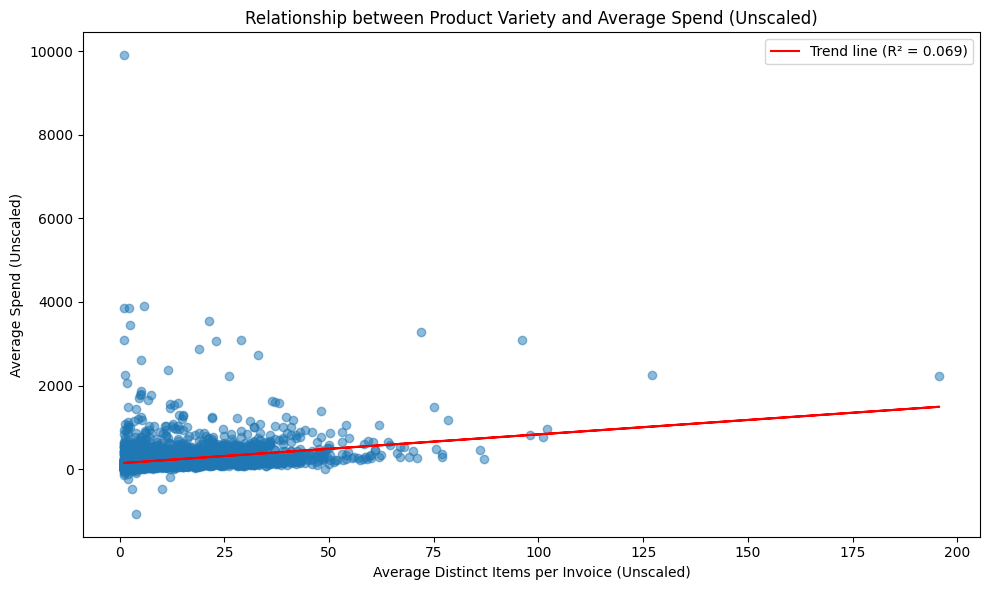

Slope: 6.906
Intercept: 140.219
R-squared: 0.069
P-value: 1.502e-69
Standard Error: 0.385

The relationship is statistically significant (p < 0.05).
There is a positive relationship between product variety and average spend.

Interpretation: For each unit increase in the Unscaled average number of distinct items per invoice, the Unscaled average spend changes by 6.91 units on average.


In [154]:
plot_product_variety_vs_spend(product_df, '', False)

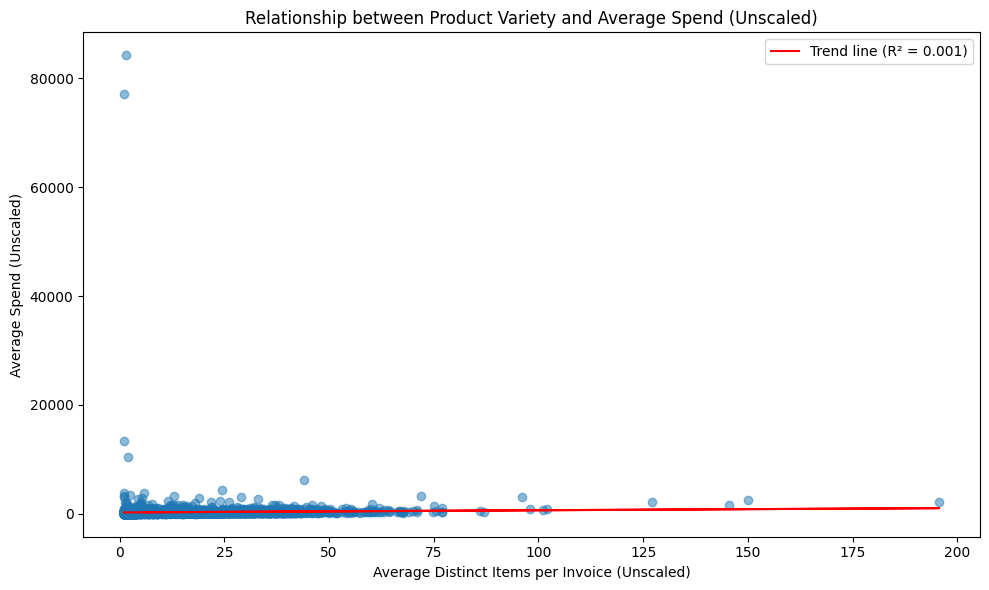

Slope: 4.029
Intercept: 247.134
R-squared: 0.001
P-value: 6.317e-02
Standard Error: 2.168

The relationship is not statistically significant (p >= 0.05).

Interpretation: For each unit increase in the Unscaled average number of distinct items per invoice, the Unscaled average spend changes by 4.03 units on average.


In [155]:
plot_product_variety_vs_spend(product_df[product_df['TotalPrice'] >= 0], '', False)

In [136]:
def plot_invoice_count_vs_spend(df, scale_method='robust', remove_outliers=True):
    df_stats = calculate_customer_statistics(df)
    
    # Extract the relevant columns
    x = df_stats['InvoiceCount'].values.reshape(-1, 1)
    y = df_stats['AvgInvoiceSpend'].values.reshape(-1, 1)

    # Remove outliers using IQR method if specified
    if remove_outliers:
        Q1 = np.percentile(np.hstack([x, y]), 25, axis=0)
        Q3 = np.percentile(np.hstack([x, y]), 75, axis=0)
        IQR = Q3 - Q1
        outlier_mask = np.any((np.hstack([x, y]) < (Q1 - 1.5 * IQR)) | (np.hstack([x, y]) > (Q3 + 1.5 * IQR)), axis=1)
        x = x[~outlier_mask]
        y = y[~outlier_mask]

    # Scale the data
    if scale_method == 'robust':
        scaler = RobustScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Robust Scaled'
    elif scale_method == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal')
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Quantile Transformed'
    elif scale_method == 'minmax':
        scaler = MinMaxScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Min-Max Normalized'
    elif scale_method == 'zscore':
        scaler = StandardScaler()
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Z-Score Standardized'
    elif scale_method == 'yeojohnson':
        scaler = PowerTransformer(method='yeo-johnson')
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = 'Yeo-Johnson Transformed'
    else:
        x_scaled, y_scaled = x, y
        scale_name = 'Unscaled'

    # Perform linear regression on scaled data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_scaled.flatten(), y_scaled.flatten())

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_scaled, y_scaled, alpha=0.5)
    plt.xlabel(f'Invoice Count ({scale_name})')
    plt.ylabel(f'Average Spend ({scale_name})')
    plt.title(f'Relationship between Number of Invoices and Average Spend ({scale_name})')

    # Create the trend line
    line = slope * x_scaled + intercept
    plt.plot(x_scaled, line, color='r', label=f'Trend line (R² = {r_value**2:.3f})')

    # Add legend and display the plot
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print regression statistics
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.3e}")
    print(f"Standard Error: {std_err:.3f}")

    # Interpret the results
    if p_value < 0.05:
        print("\nThe relationship is statistically significant (p < 0.05).")
        if slope > 0:
            print("There is a positive relationship between number of invoices and average spend.")
        else:
            print("There is a negative relationship between number of invoices and average spend.")
    else:
        print("\nThe relationship is not statistically significant (p >= 0.05).")

    if scale_method != 'none':
        print(f"\nInterpretation: For each unit increase in the {scale_name} number of invoices, "
              f"the {scale_name} average spend changes by {slope:.2f} units on average.")
    else:
        print(f"\nInterpretation: For each additional invoice, "
              f"the average spend changes by £{slope:.2f} on average.")

    # Print the number of outliers removed
    if remove_outliers:
        print(f"\nNumber of outliers removed: {len(df) - len(x)}")

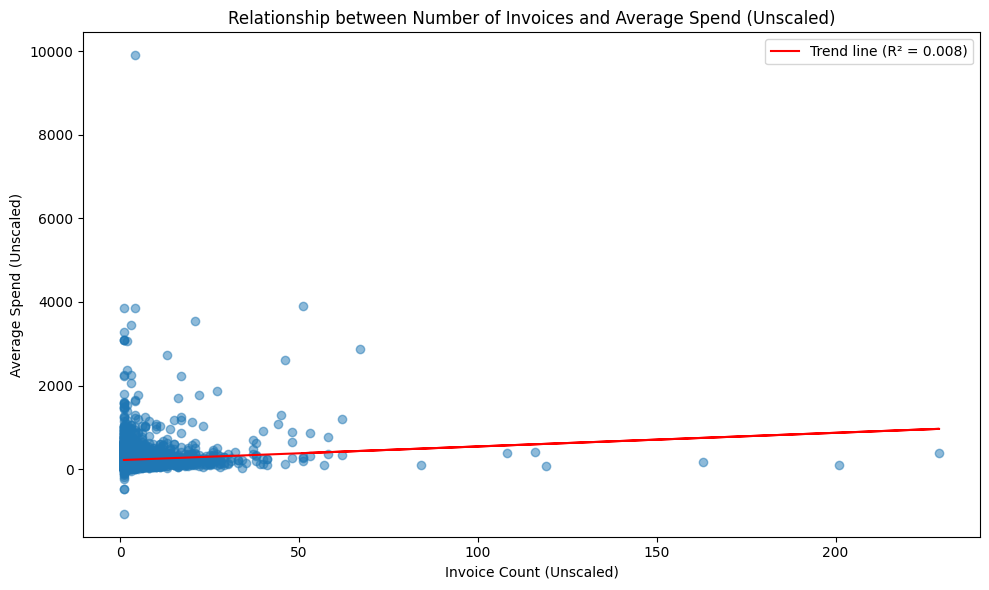

Slope: 3.267
Intercept: 215.119
R-squared: 0.008
P-value: 1.677e-09
Standard Error: 0.541

The relationship is statistically significant (p < 0.05).
There is a positive relationship between number of invoices and average spend.

Interpretation: For each unit increase in the Unscaled number of invoices, the Unscaled average spend changes by 3.27 units on average.


In [156]:
plot_invoice_count_vs_spend(product_df, '', False)

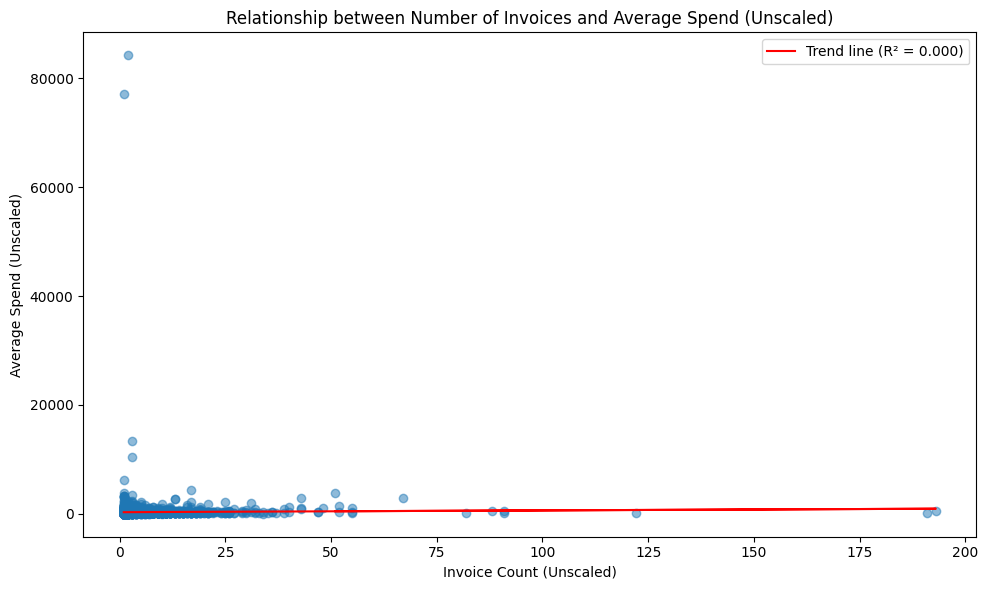

Slope: 3.328
Intercept: 290.944
R-squared: 0.000
P-value: 3.716e-01
Standard Error: 3.725

The relationship is not statistically significant (p >= 0.05).

Interpretation: For each unit increase in the Unscaled number of invoices, the Unscaled average spend changes by 3.33 units on average.


In [157]:
plot_invoice_count_vs_spend(product_df[product_df['TotalPrice'] >= 0], '', False)

In [158]:
def analyse_customer_data(df):
    def check_uppercase(text):
        if not isinstance(text, str):
            return False
        if text.startswith('*'):
            return True
        pattern = r'^([A-Z]{5,}|\d\s?[A-Z]{4,})'
        return bool(re.match(pattern, text))

    def product_filter(df):
        mask = df['Description'].apply(check_uppercase) | (df['Description'] == 'Manual')
        return df[mask]

    def remove_postage_amazon_rows(df):
        mask = ~df['Description'].str.lower().str.contains('postage|amazon')
        return df[mask]

    # Step 1: Filter out non-product rows
    df_products = remove_postage_amazon_rows(df)
    df_products = product_filter(df_products)

    # Step 2: Calculate total spend for each customer (including all data)
    total_spend = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()

    # Step 3: Calculate the number of distinct invoices for each customer
    invoice_sums = df_products.groupby(['CustomerID', 'InvoiceDate'])['TotalPrice'].sum().reset_index()
    distinct_invoices = invoice_sums[invoice_sums['TotalPrice'] > 0].groupby('CustomerID').size().reset_index(name='DistinctInvoices')

    # Step 4: Calculate average number of distinct products per invoice
    products_per_invoice = df_products.groupby(['CustomerID', 'InvoiceDate'])['Description'].nunique().reset_index(name='DistinctProducts')
    avg_products_per_invoice = products_per_invoice.groupby('CustomerID')['DistinctProducts'].mean().reset_index(name='AvgProductsPerInvoice')

    # Step 5: Merge all results
    result = pd.merge(total_spend, distinct_invoices, on='CustomerID', how='inner')
    result = pd.merge(result, avg_products_per_invoice, on='CustomerID', how='left')

    # Step 6: Calculate average spend per invoice
    result['AverageSpendPerInvoice'] = result['TotalPrice'] / result['DistinctInvoices']
    result['AverageSpendPerInvoice'] = result['AverageSpendPerInvoice'].replace([np.inf, -np.inf], np.nan)

    return result

In [159]:

def plot_customer_metrics_regression(df, x_var, scale_method='robust', remove_outliers=True):
    # Extract the relevant columns
    x = df[x_var].values.reshape(-1, 1)
    y = df['AverageSpendPerInvoice'].values.reshape(-1, 1)

    # Remove outliers using IQR method if specified
    if remove_outliers:
        Q1 = np.percentile(np.hstack([x, y]), 25, axis=0)
        Q3 = np.percentile(np.hstack([x, y]), 75, axis=0)
        IQR = Q3 - Q1
        outlier_mask = np.any((np.hstack([x, y]) < (Q1 - 1.5 * IQR)) | (np.hstack([x, y]) > (Q3 + 1.5 * IQR)), axis=1)
        x = x[~outlier_mask]
        y = y[~outlier_mask]

    # Scale the data
    if scale_method == 'robust':
        scaler = RobustScaler()
    elif scale_method == 'quantile':
        scaler = QuantileTransformer(output_distribution='normal')
    elif scale_method == 'minmax':
        scaler = MinMaxScaler()
    elif scale_method == 'zscore':
        scaler = StandardScaler()
    elif scale_method == 'yeojohnson':
        scaler = PowerTransformer(method='yeo-johnson')
    else:
        scaler = None

    if scaler:
        x_scaled = scaler.fit_transform(x)
        y_scaled = scaler.fit_transform(y)
        scale_name = scaler.__class__.__name__
    else:
        x_scaled, y_scaled = x, y
        scale_name = 'Unscaled'

    # Perform linear regression on scaled data
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_scaled.flatten(), y_scaled.flatten())

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_scaled, y_scaled, alpha=0.5)
    plt.xlabel(f'{x_var} ({scale_name})')
    plt.ylabel(f'Average Spend Per Invoice ({scale_name})')
    plt.title(f'Relationship between {x_var} and Average Spend Per Invoice ({scale_name})')

    # Create the trend line
    line = slope * x_scaled + intercept
    plt.plot(x_scaled, line, color='r', label=f'Trend line (R² = {r_value**2:.3f})')

    # Add legend and display the plot
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print regression statistics
    print(f"Slope: {slope:.3f}")
    print(f"Intercept: {intercept:.3f}")
    print(f"R-squared: {r_value**2:.3f}")
    print(f"P-value: {p_value:.3e}")
    print(f"Standard Error: {std_err:.3f}")

    # Interpret the results
    if p_value < 0.05:
        print("\nThe relationship is statistically significant (p < 0.05).")
        if slope > 0:
            print(f"There is a positive relationship between {x_var} and average spend per invoice.")
        else:
            print(f"There is a negative relationship between {x_var} and average spend per invoice.")
    else:
        print("\nThe relationship is not statistically significant (p >= 0.05).")

    if scale_method != 'none':
        print(f"\nInterpretation: For each unit increase in the {scale_name} {x_var}, "
              f"the {scale_name} average spend per invoice changes by {slope:.2f} units on average.")
    else:
        print(f"\nInterpretation: For each unit increase in {x_var}, "
              f"the average spend per invoice changes by £{slope:.2f} on average.")

    # Print the number of outliers removed
    if remove_outliers:
        print(f"\nNumber of outliers removed: {np.sum(outlier_mask)}")

In [160]:
final_df = analyse_customer_data(df)

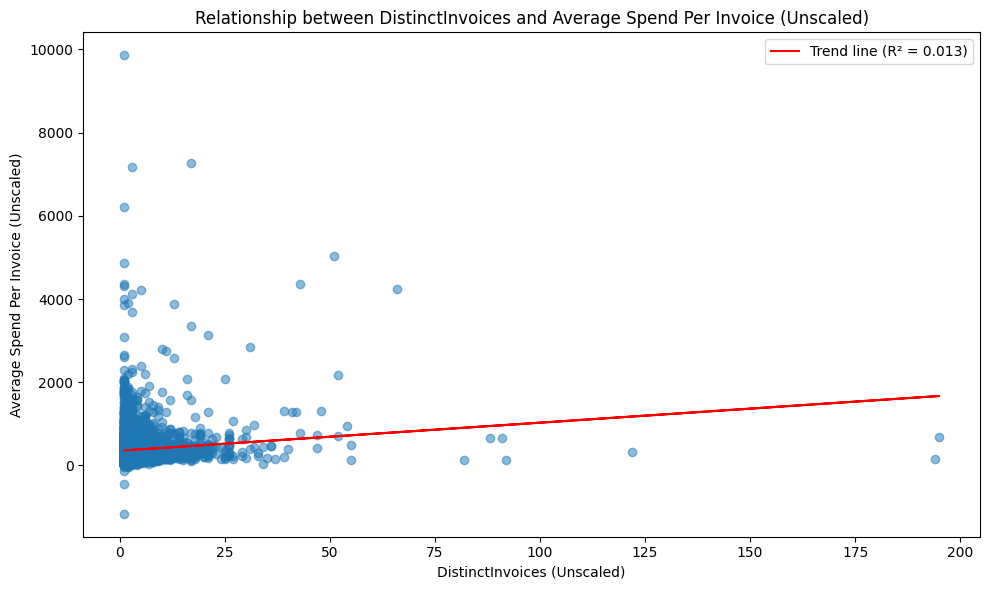

Slope: 6.752
Intercept: 350.779
R-squared: 0.013
P-value: 1.157e-13
Standard Error: 0.907

The relationship is statistically significant (p < 0.05).
There is a positive relationship between DistinctInvoices and average spend per invoice.

Interpretation: For each unit increase in the Unscaled DistinctInvoices, the Unscaled average spend per invoice changes by 6.75 units on average.


In [161]:
plot_customer_metrics_regression(final_df, 'DistinctInvoices', '', False)

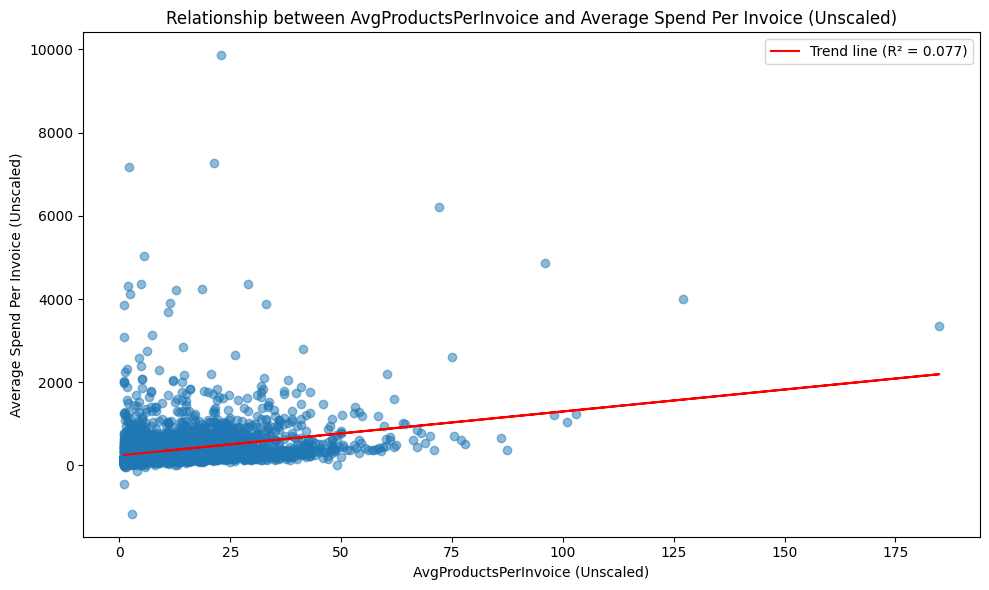

Slope: 10.552
Intercept: 240.594
R-squared: 0.077
P-value: 7.864e-77
Standard Error: 0.557

The relationship is statistically significant (p < 0.05).
There is a positive relationship between AvgProductsPerInvoice and average spend per invoice.

Interpretation: For each unit increase in the Unscaled AvgProductsPerInvoice, the Unscaled average spend per invoice changes by 10.55 units on average.


In [162]:
plot_customer_metrics_regression(final_df, 'AvgProductsPerInvoice', '', False)

### Exploring product returns (scrapped)

In [109]:
# negative_quantity = df[df['Quantity'] < 0]

# negative_quantity_count = len(negative_quantity)

# print(negative_quantity_count)

# negative_quantity.head()
# def analyze_and_print_results(negative_quantity):
#     # Count how many negative quantity rows have matching positive quantity rows
#     rows_with_matches = negative_quantity['matching_positive'].apply(lambda x: not x.empty)
#     match_count = rows_with_matches.sum()

#     print(f"Total negative quantity rows: {len(negative_quantity)}")
#     print(f"Negative quantity rows with matching positive quantity rows: {match_count}")
#     print(f"Percentage of likely returns: {match_count / len(negative_quantity) * 100:.2f}%")

#     # Display a few examples of matches
#     if not negative_quantity[rows_with_matches].empty:
#         print("\nExample of a negative quantity row with its matching positive quantity row:")
#         example = negative_quantity[rows_with_matches].iloc[0]
#         print("\nNegative quantity row:")
#         print(example[['Description', 'CustomerID', 'UnitPrice', 'Quantity']])
#         print("\nMatching positive quantity row(s):")
#         print(example['matching_positive'][['Description', 'CustomerID', 'UnitPrice', 'Quantity']])

#     # Check for multiple matches
#     multiple_matches = negative_quantity['matching_positive'].apply(len)
#     print(f"\nRows with multiple matching positive quantity entries: {(multiple_matches > 1).sum()}")

#     # Check for unmatched negative quantity rows
#     unmatched = negative_quantity[~rows_with_matches]
#     print(f"\nNumber of negative quantity rows without matches: {len(unmatched)}")
#     if not unmatched.empty:
#         print("\nExample of an unmatched negative quantity row:")
#         print(unmatched.iloc[0][['Description', 'CustomerID', 'UnitPrice', 'Quantity']])
# def find_potential_matching_positive(row, full_dataset):
#     mask = (
#         (full_dataset['Description'] == row['Description']) &
#         (full_dataset['CustomerID'] == row['CustomerID']) &
#         (full_dataset['UnitPrice'] == row['UnitPrice']) &
#         (full_dataset['Quantity'] > 0) &  # Positive quantity
#         (full_dataset['Quantity'] <= -row['Quantity']) &  # Not bigger than the absolute negative value
#         (full_dataset['InvoiceDate'] <= row['InvoiceDate'])  # Earlier date
#     )
#     return full_dataset[mask]

# potential_matching_negative = negative_quantity.assign(matching_positive=negative_quantity.apply(lambda row: find_potential_matching_positive(row, df_cleaned), axis=1))

# analyze_and_print_results(potential_matching_negative)